# Lista 3 Problema 4 Individual - Ajuste de salario - Código para el problema

In [1]:
!pip install torch --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu


In [2]:
!pip install --user --upgrade apafib

In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from apafib import load_wages

In [4]:
class wagesDataset(Dataset):

    def __init__(self, data, labels):
        self.data = torch.Tensor(data).float()
        self.labels = torch.Tensor(labels).float()

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]

        return x, y

    def __len__(self):
        return len(self.data)

# wages_train = torch.utils.data.DataLoader(wagesDataset(X_train, y_train), batch_size=32)

In [5]:
def RegressionLoss(y, y_hat):
    """ Heteroscedastic regression loss

    y: valores reales (batch_size,)
    y_hat: valores predichos (batch_size, 2)
    """
    mean = y_hat[:, 0]
    logvar = y_hat[:, 1]
    square = (mean - y).square()
    sigsq = (logvar.exp() + 1e-5)
    ms = (square / sigsq + logvar)
    return ms.mean()

In [6]:
# Funcion para entrenar el modelo
def train_loop(model, train, val, optimizer, scheduler=None, patience=5, epochs=100, lossf=F.mse_loss):
    """_Bucle de entrenamiento_

    Args:
        model: red a entrenar
        optimizer: optimizador de pytorch, por ejemplo torch.optim.Adam
        train: datos de entrenamiento
        val: datos de validacion
        epochs: numero de epochs

    Returns:
        _type_: _description_
    """
    def epoch_loss(dataset):
        data_loss = 0.0
        for i, (data, labels) in enumerate(dataset):
            inputs = data.to('cuda')
            y = labels.to('cuda')
            outputs = model(inputs)
            loss = lossf(y, outputs)
            data_loss += loss.item()
        return data_loss / i

    def early_stopping(val_loss, patience=5):
        if len(val_loss) > patience:
            if val_loss[-1] > np.mean(val_loss[-(patience+1):-1]):
                return True

    hist_loss = {'train': [], 'val': []}
    pbar = tqdm(range(epochs))
    for epoch in pbar:  # bucle para todos los epochs
        for i, (data, labels) in enumerate(train):
            # obtenemos los datos y los subimos a la GPU
            inputs = data.to('cuda')
            y = labels.to('cuda')

            # Reiniciamos los gradientes
            optimizer.zero_grad()

            # Aplicamos los datos al modelo
            outputs = model(inputs)
            # Calculamos la perdida
            loss = lossf(y, outputs)

            # Hacemos el paso hacia atras
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        # Calculamos la perdida en el conjunto de entrenamiento y validacion
        with torch.no_grad():
            hist_loss['train'].append(epoch_loss(train))
            hist_loss['val'].append(epoch_loss(val))

        # Mostramos la perdida en el conjunto de entrenamiento y validacion
        pbar.set_postfix({'train': hist_loss['train'][-1], 'val': hist_loss['val'][-1]})

        # Si la perdida en el conjunto de validacion no disminuye, paramos el entrenamiento
        if early_stopping(hist_loss['val'], patience):
            break

    return hist_loss

# Para el optimizador podemos usar Adam, le pasaremos el siguiente objeto
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# donde model es el modelo que queremos entrenar
# y lr es la tasa de aprendizaje, 1e-4 es un valor comun

In [7]:
# Clase para definir la arquitectura del MLP
class MLPRegressor(nn.Module):

    def __init__(self,
                 input_size,
                 hidden_layers_sizes,
                 activation=nn.ReLU,
                 var=True):
        super(MLPRegressor, self).__init__()
        self.layers = []
        self.fc1 = nn.Linear(input_size, hidden_layers_sizes[0])
        self.layers.append(self.fc1)
        self.layers.append(activation())
        for i in range(1, len(hidden_layers_sizes)):
            self.layers.append(
                nn.Linear(hidden_layers_sizes[i - 1], hidden_layers_sizes[i]))
            self.layers.append(activation())
        self.layers = nn.Sequential(*self.layers)
        if var:
            self.output = nn.Linear(hidden_layers_sizes[-1], 2)
        else:
            self.output = nn.Linear(hidden_layers_sizes[-1], 1)
    def forward(self, x):
        return self.output(self.layers(x.view(x.size(0), -1)))

In [8]:
def test_model(model, test):
    """
    Función para obtener las predicciones de un modelo de regresión

    Args:
        model: modelo entrenado
        test: conjunto de test (DataLoader)

    Returns:
        predicciones, valores reales (ambos como arrays 1D)
    """
    preds = []
    true = []
    for i, (data, labels) in enumerate(test):
        inputs = data.to('cuda')
        outputs = model(inputs)
        preds.append(outputs.detach().cpu().numpy())
        true.append(labels.detach().cpu().numpy())


    return np.concatenate(preds). flatten(), np.concatenate(true). flatten()


# Apartado A

Para este apartado se pide dividir el conjunto de datos en tres partes, el conjunto de entrenamiento (80 %), el conjunto de validación (10 %) y el conjunto de test (10 %). Además, se comprobará la variabilidad de la variable objetivo wages, respecto las demás variables y se aplicara un escalado min-max al conjunto de datos

In [9]:
from apafib import load_wages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [10]:
df = load_wages()
df.head()

,wage,educ,exper,fulltime,hrswk,nkids,age,married,female,insurance,...,mcaid,mcare,metro,northeast,midwest,south,west,white,black,asian
0,18.70,16,39,1,37,0,58,1,1,1,...,0,0,1,0,0,1,0,1,0,0
1,11.50,12,16,1,62,2,31,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,15.04,16,13,1,40,0,32,1,0,1,...,0,0,1,0,0,0,1,0,1,0
3,25.95,14,11,1,40,3,29,0,1,1,...,0,0,1,0,0,1,0,0,1,0
4,24.03,12,51,1,40,0,66,1,0,1,...,0,0,1,1,0,0,0,1,0,0


Primero separamos las variables predictoras (X) de la variable objetivo (y = wage). Después hacemos la división del conjunto de datos.



In [11]:

X = df.loc[:,df.columns != 'wage']
y = df['wage']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [12]:
print(df.columns.tolist())


['wage', 'educ', 'exper', 'fulltime', 'hrswk', 'nkids', 'age', 'married', 'female', 'insurance', 'private', 'mcaid', 'mcare', 'metro', 'northeast', 'midwest', 'south', 'west', 'white', 'black', 'asian']


Para continuar con el apartado se nos pide combrobar la diferente variabilidad de la variable objetivo representándola respecto a las variables del conjunto fijándonos en las variables que deberían tener una relación creciente con el salario. Se ha considerado que, viendo el conjunto de variables las que tienen una relación creciente esperada con wage son: educ (años de educación), exper (años de experiencia), age (edad) y hrswk (horas trabajadas por semana).

Para poder detectar la heteroscedasticidad se han hecho diferentes scatters plots de wage vs las variables del conjunto de datos, agrupación en bins (20 intervalos por variable) para calcular la media y desviación estándar de wage en cada grupo. Finalmente, se visualiza una zona sombreada roja alrededor de la línea de media. Si la banda se ensancha o estrecha a lo largo de la variable, existe heterocedasticidad ya que hay varianza cambiante si la banda es constante, hay homocedasticidad (varianza fija).

ANÁLISIS DE HETEROCEDASTICIDAD
Comprobando la diferente variabilidad de wage respecto a las variables


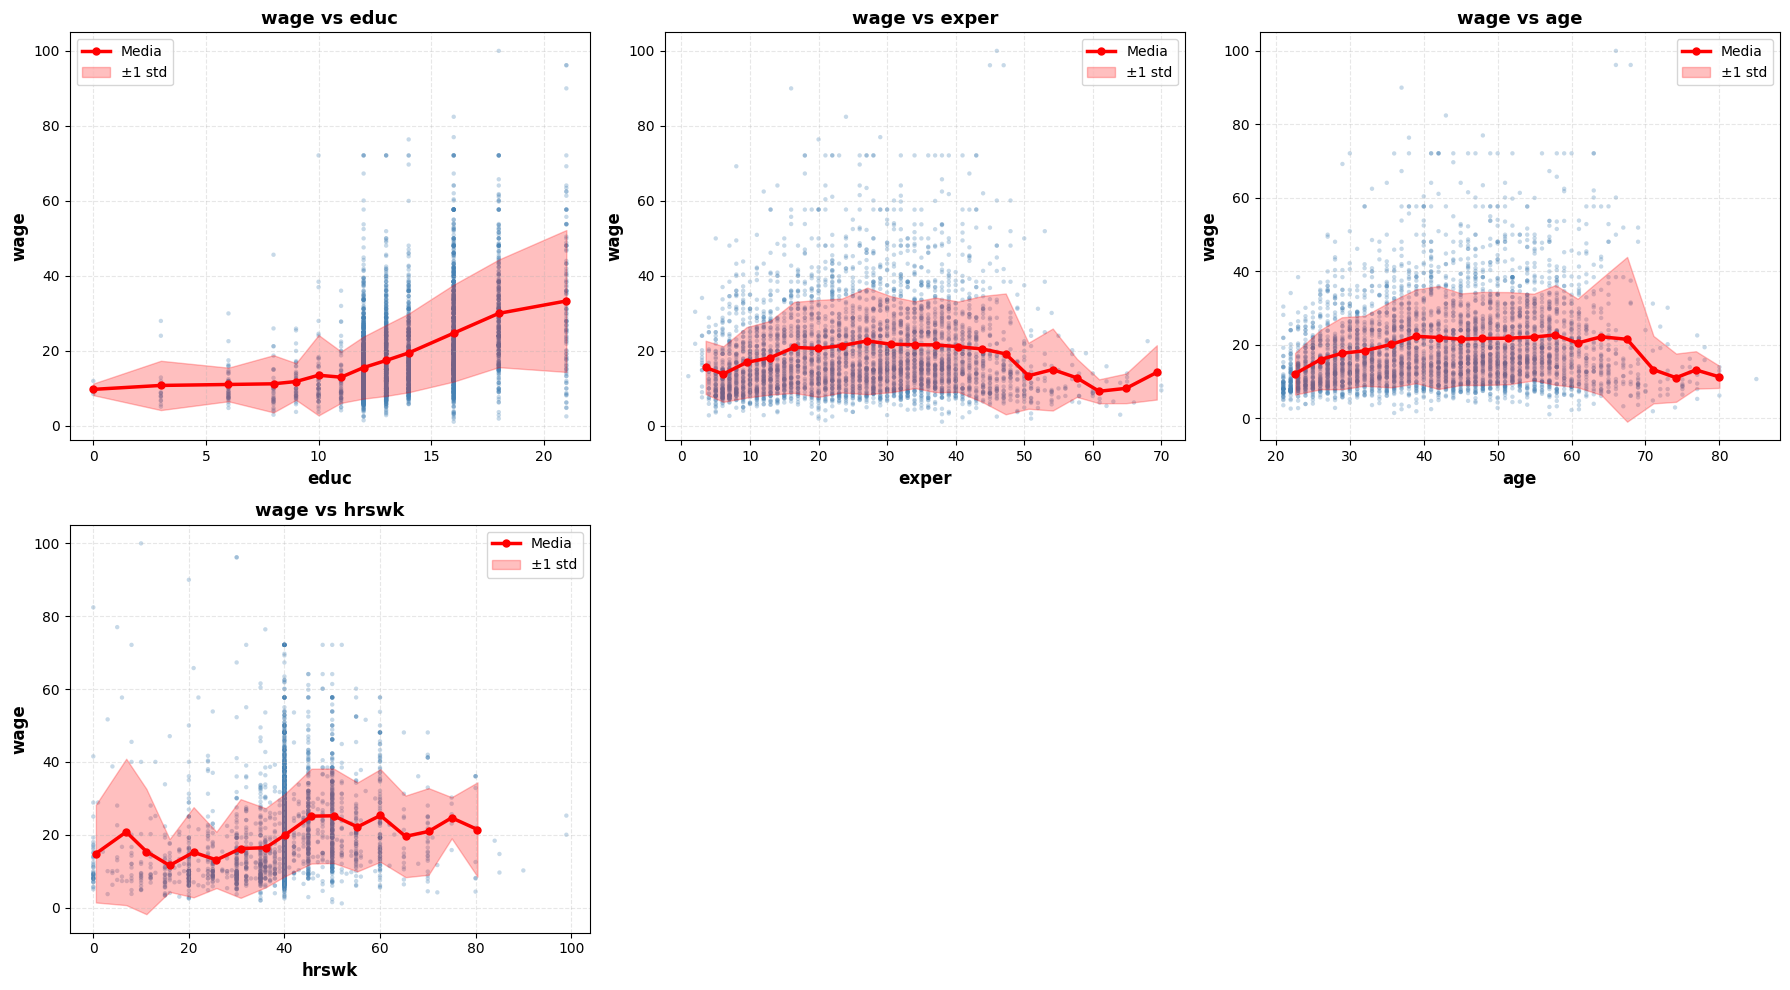

ANÁLISIS COMPLETO DE TODAS LAS VARIABLES (20 variables):
['educ', 'exper', 'fulltime', 'hrswk', 'nkids', 'age', 'married', 'female', 'insurance', 'private', 'mcaid', 'mcare', 'metro', 'northeast', 'midwest', 'south', 'west', 'white', 'black', 'asian']


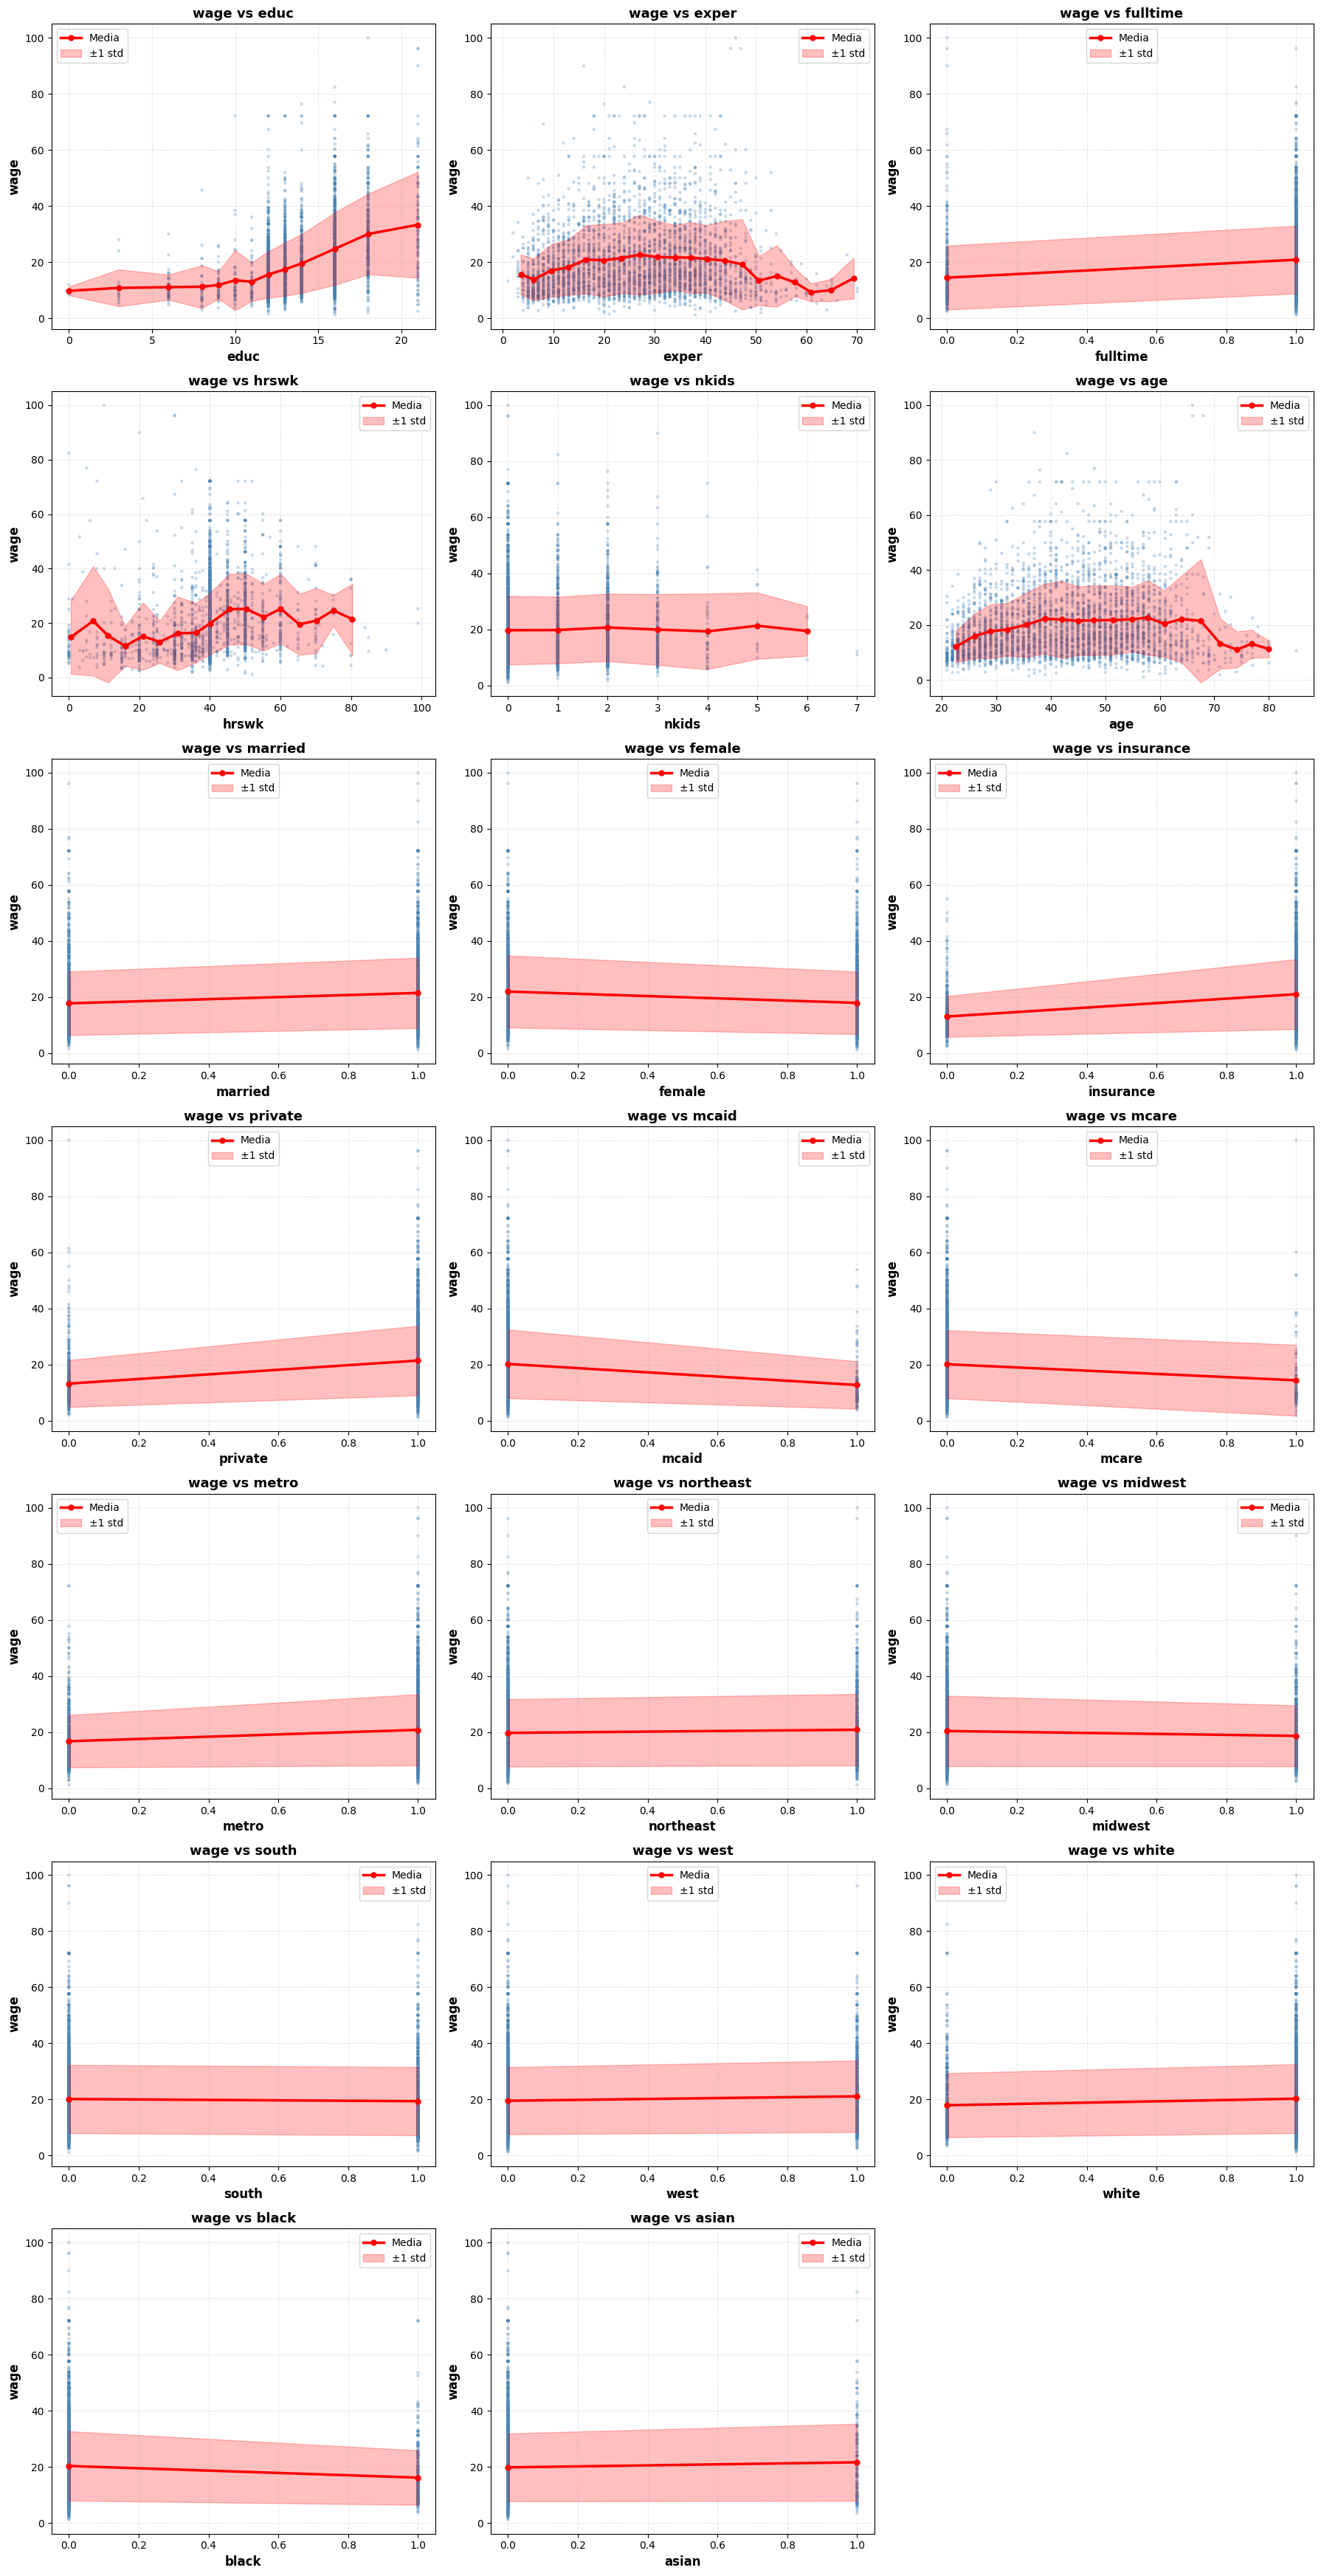

In [14]:
def plot_heteroscedasticity(X, y, variables, title_suffix="", n_bins=20):

    n = len(variables)
    n_cols = min(3, n)
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes
    else:
        axes = axes.flatten()

    for idx, var in enumerate(variables):
        ax = axes[idx] if n > 1 else axes

        ax.scatter(X[var], y, alpha=0.3, s=10, color='steelblue', edgecolors='none')

        df_temp = pd.DataFrame({var: X[var]. values, 'wage': y. values})
        df_temp['bin'] = pd.cut(df_temp[var], bins=n_bins, duplicates='drop')

        stats = df_temp.groupby('bin', observed=True).agg({
            var: 'mean',
            'wage': ['mean', 'std', 'count']
        })

        stats = stats[stats[('wage', 'count')] >= 3]. dropna()

        if len(stats) > 0:
            x_centers = stats[(var, 'mean')].values
            y_means = stats[('wage', 'mean')].values
            y_stds = stats[('wage', 'std')].values

            ax.plot(x_centers, y_means, 'r-', linewidth=2.5,
                   label='Media', marker='o', markersize=5)
            ax.fill_between(x_centers,
                           y_means - y_stds,
                           y_means + y_stds,
                           color='red', alpha=0.25, label='±1 std')

        ax.set_xlabel(var, fontsize=12, fontweight='bold')
        ax.set_ylabel('wage', fontsize=12, fontweight='bold')
        ax.set_title(f'wage vs {var}', fontsize=13, fontweight='bold')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3, linestyle='--')


    if n > 1:
        for idx in range(len(variables), len(axes) if hasattr(axes, '__len__') else 1):
            if hasattr(axes, '__len__'):
                axes[idx].set_visible(False)

    plt.tight_layout()
    filename = f'heteroscedasticity{title_suffix}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()



print("ANÁLISIS DE HETEROCEDASTICIDAD")
print("Comprobando la diferente variabilidad de wage respecto a las variables")


all_vars = list(X_train.columns)
key_vars = ['educ', 'exper', 'age', 'hrswk']


plot_heteroscedasticity(X_train, y_train, key_vars, title_suffix="_key_vars")



print(f"ANÁLISIS COMPLETO DE TODAS LAS VARIABLES ({len(all_vars)} variables):")

print(all_vars)
plot_heteroscedasticity(X_train, y_train, all_vars, title_suffix="_all_vars")


Podemos observar que con la variable educación existe una relación creciente, por tanto las personas con educación tienen salarios muy variables lo que refleja diferencias en el mercado laboral cualificado. Con la variable exper y edad ocurre algo similar: hay un inicio creiciente y después decreciente lo que puede indicar que con experiencia laboral alta los salarios se homegeneizan. Si observamos la variable hrswk, hay una heterocedasticidad muy fuerte y variable, por tanto las personas que trabajan muchas horas tienen salarios muy diferentes.

En conclusión, se confirma la presencia de heterocedasticidad clara en las cuatro variables económicas clave (educ, exper, age, hrswk), siendo hrswk y educ las que presentan mayor variabilidad. Por el contrario, las variables binarias y categóricas (geográficas, demográficas, laborales) muestran homocedasticidad con bandas de varianza constantes, siendo útiles únicamente para capturar diferencias de media salarial entre grupos pero no de varianza. Estos resultados justifican plenamente el uso de un modelo heterocedástico que pueda capturar la varianza cambiante del salario en función de las características de cada individuo, en lugar de asumir una varianza constante como haría un modelo homocedástico estándar.

Para acabar el apartado, se realiza un escalado Min-Max como indica el enunciado. Este es un paso de preprocesamiento esencial antes de entrenar modelos de redes neuronales, ya que normaliza todas las variables al mismo rango, evitando que variables con magnitudes mayores dominen el aprendizaje del modelo.

In [15]:
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)


print("\nVerificación - Todos los valores deben estar en [0, 1]:")
print(X_train_scaled.describe().loc[['min', 'max']])





Verificación - Todos los valores deben estar en [0, 1]:
     educ  exper  fulltime  hrswk  nkids  age  married  female  insurance  \
min   0.0    0.0       0.0    0.0    0.0  0.0      0.0     0.0        0.0   
max   1.0    1.0       1.0    1.0    1.0  1.0      1.0     1.0        1.0   

     private  mcaid  mcare  metro  northeast  midwest  south  west  white  \
min      0.0    0.0    0.0    0.0        0.0      0.0    0.0   0.0    0.0   
max      1.0    1.0    1.0    1.0        1.0      1.0    1.0   1.0    1.0   

     black  asian  
min    0.0    0.0  
max    1.0    1.0  


# Apartado B

Para este apartado, se nos pide entrenar diferentes arquitecturas de redes neuronales tipo MLP para resolver el problema de regresión de predicción de salarios (wage).

Primero empezamos convirtiendo los datos escalados a numpy arrays. Se fija la semilla aleatoria (torch.manual_seed(42)) para garantizar la reproducibilidad de los resultados.

In [16]:
torch.manual_seed(42)

# Convertir datos escalados a numpy arrays
X_train_np = X_train_scaled.values.astype(np.float32)
X_val_np = X_val_scaled.values.astype(np.float32)
X_test_np = X_test_scaled.values.astype(np.float32)

y_train_np = y_train.values.astype(np. float32)
y_val_np = y_val.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)


WAGE_train = DataLoader(wagesDataset(X_train_np, y_train_np), batch_size=64, shuffle=True)
WAGE_val = DataLoader(wagesDataset(X_val_np, y_val_np), batch_size=64, shuffle=False)
WAGE_test = DataLoader(wagesDataset(X_test_np, y_test_np), batch_size=64, shuffle=False)


input_size = X_train_np.shape[1]
output_size = 1

print(f"\nInput size: {input_size}")
print(f"Output size: {output_size}")
print(f"Train batches: {len(WAGE_train)}")
print(f"Val batches: {len(WAGE_val)}")
print(f"Test batches: {len(WAGE_test)}")



Input size: 20
Output size: 1
Train batches: 61
Val batches: 8
Test batches: 8


A continuación, se crean 4 modelos MLP con 1 capa oculta de tamaños crecientes ([32], [64], [128], [256]), utilizando activación ReLU. Cada modelo se entrena usando el optimizador Adam con la función de pérdida MSE, aplicando early stopping, guardando el historial de pérdidas de entrenamiento y validación para análisis posterior.

In [17]:
# Model_ReLU_1_32: 1 hidden layer [32], activation ReLU
Model_ReLU_1_32 = MLPRegressor(input_size, hidden_layers_sizes=[32],
                               activation=nn.ReLU, var=False). to('cuda')

# Model_ReLU_1_64: 1 hidden layer [64], activation ReLU
Model_ReLU_1_64 = MLPRegressor(input_size, hidden_layers_sizes=[64],
                               activation=nn.ReLU, var=False).to('cuda')

# Model_ReLU_1_128: 1 hidden layer [128], activation ReLU
Model_ReLU_1_128 = MLPRegressor(input_size, hidden_layers_sizes=[128],
                                activation=nn.ReLU, var=False).to('cuda')

# Model_ReLU_1_256: 1 hidden layer [256], activation ReLU
Model_ReLU_1_256 = MLPRegressor(input_size, hidden_layers_sizes=[256],
                                activation=nn.ReLU, var=False).to('cuda')

# Entrenar modelos de 1 capa ReLU
optimizer = optim.Adam(Model_ReLU_1_32.parameters(), lr=1e-3)
history_relu_1_32 = train_loop(Model_ReLU_1_32, WAGE_train, WAGE_val, optimizer,
                               patience=10, epochs=500, lossf=F.mse_loss)

optimizer = optim.Adam(Model_ReLU_1_64. parameters(), lr=1e-3)
history_relu_1_64 = train_loop(Model_ReLU_1_64, WAGE_train, WAGE_val, optimizer,
                               patience=10, epochs=500, lossf=F.mse_loss)

optimizer = optim.Adam(Model_ReLU_1_128.parameters(), lr=1e-3)
history_relu_1_128 = train_loop(Model_ReLU_1_128, WAGE_train, WAGE_val, optimizer,
                                patience=10, epochs=500, lossf=F.mse_loss)

optimizer = optim. Adam(Model_ReLU_1_256.parameters(), lr=1e-3)
history_relu_1_256 = train_loop(Model_ReLU_1_256, WAGE_train, WAGE_val, optimizer,
                                patience=10, epochs=500, lossf=F.mse_loss)

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-2175505420.py:44: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = lossf(y, outputs)
/tmp/ipython-input-2175505420.py:44: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = lossf(y, outputs)
/tmp/ipython-input-2175505420.py:21: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = lossf(y, outputs)
/tmp/ipython-input-2175505420.py:21: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30])). This will likely l

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Se crean 4 modelos MLP con 2 capas ocultas donde la segunda capa tiene la mitad de neuronas que la primera ([32,16], [64,32], [128,64], [256,128]), utilizando activación ReLU y configuración var=False. Cada modelo se entrena con Adam (lr=1e-3) y MSE loss, aplicando las mismas condiciones de early stopping para comparar el efecto del aumento de profundidad en el rendimiento.

In [18]:
# Model_ReLU_2_32: 2 hidden layers [32, 16], activation ReLU
Model_ReLU_2_32 = MLPRegressor(input_size, hidden_layers_sizes=[32, 16],
                               activation=nn.ReLU, var=False).to('cuda')

# Model_ReLU_2_64: 2 hidden layers [64, 32], activation ReLU
Model_ReLU_2_64 = MLPRegressor(input_size, hidden_layers_sizes=[64, 32],
                               activation=nn.ReLU, var=False).to('cuda')

# Model_ReLU_2_128: 2 hidden layers [128, 64], activation ReLU
Model_ReLU_2_128 = MLPRegressor(input_size, hidden_layers_sizes=[128, 64],
                                activation=nn.ReLU, var=False).to('cuda')

# Model_ReLU_2_256: 2 hidden layers [256, 128], activation ReLU
Model_ReLU_2_256 = MLPRegressor(input_size, hidden_layers_sizes=[256, 128],
                                activation=nn.ReLU, var=False).to('cuda')

# Entrenar modelos de 2 capas ReLU
optimizer = optim.Adam(Model_ReLU_2_32.parameters(), lr=1e-3)
history_relu_2_32 = train_loop(Model_ReLU_2_32, WAGE_train, WAGE_val, optimizer,
                               patience=10, epochs=500, lossf=F.mse_loss)

optimizer = optim.Adam(Model_ReLU_2_64. parameters(), lr=1e-3)
history_relu_2_64 = train_loop(Model_ReLU_2_64, WAGE_train, WAGE_val, optimizer,
                               patience=10, epochs=500, lossf=F.mse_loss)

optimizer = optim.Adam(Model_ReLU_2_128.parameters(), lr=1e-3)
history_relu_2_128 = train_loop(Model_ReLU_2_128, WAGE_train, WAGE_val, optimizer,
                                patience=10, epochs=500, lossf=F.mse_loss)

optimizer = optim. Adam(Model_ReLU_2_256.parameters(), lr=1e-3)
history_relu_2_256 = train_loop(Model_ReLU_2_256, WAGE_train, WAGE_val, optimizer,
                                patience=10, epochs=500, lossf=F.mse_loss)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-2175505420.py:44: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = lossf(y, outputs)
/tmp/ipython-input-2175505420.py:44: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = lossf(y, outputs)
/tmp/ipython-input-2175505420.py:21: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = lossf(y, outputs)
/tmp/ipython-input-2175505420.py:21: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30])). This will likely l

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Seguimos entrenando modelos esta vez con Sigmoid y una capa oculta, siguiendo la estructura de antes

In [19]:
# Model_Sig_1_32: 1 hidden layer [32], activation Sigmoid
Model_Sig_1_32 = MLPRegressor(input_size, hidden_layers_sizes=[32],
                              activation=nn.Sigmoid, var=False).to('cuda')

# Model_Sig_1_64: 1 hidden layer [64], activation Sigmoid
Model_Sig_1_64 = MLPRegressor(input_size, hidden_layers_sizes=[64],
                              activation=nn.Sigmoid, var=False). to('cuda')

# Model_Sig_1_128: 1 hidden layer [128], activation Sigmoid
Model_Sig_1_128 = MLPRegressor(input_size, hidden_layers_sizes=[128],
                               activation=nn.Sigmoid, var=False).to('cuda')

# Model_Sig_1_256: 1 hidden layer [256], activation Sigmoid
Model_Sig_1_256 = MLPRegressor(input_size, hidden_layers_sizes=[256],
                               activation=nn.Sigmoid, var=False). to('cuda')

# Entrenar modelos de 1 capa Sigmoid
optimizer = optim.Adam(Model_Sig_1_32.parameters(), lr=1e-3)
history_sig_1_32 = train_loop(Model_Sig_1_32, WAGE_train, WAGE_val, optimizer,
                              patience=10, epochs=500, lossf=F.mse_loss)

optimizer = optim.Adam(Model_Sig_1_64.parameters(), lr=1e-3)
history_sig_1_64 = train_loop(Model_Sig_1_64, WAGE_train, WAGE_val, optimizer,
                              patience=10, epochs=500, lossf=F.mse_loss)

optimizer = optim.Adam(Model_Sig_1_128. parameters(), lr=1e-3)
history_sig_1_128 = train_loop(Model_Sig_1_128, WAGE_train, WAGE_val, optimizer,
                               patience=10, epochs=500, lossf=F.mse_loss)

optimizer = optim.Adam(Model_Sig_1_256.parameters(), lr=1e-3)
history_sig_1_256 = train_loop(Model_Sig_1_256, WAGE_train, WAGE_val, optimizer,
                               patience=10, epochs=500, lossf=F.mse_loss)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-2175505420.py:44: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = lossf(y, outputs)
/tmp/ipython-input-2175505420.py:44: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = lossf(y, outputs)
/tmp/ipython-input-2175505420.py:21: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = lossf(y, outputs)
/tmp/ipython-input-2175505420.py:21: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30])). This will likely l

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Por último entrenamos los modelos con Sigmoid y dos capas ocultas

In [20]:
# Model_Sig_2_32: 2 hidden layers [32, 16], activation Sigmoid
Model_Sig_2_32 = MLPRegressor(input_size, hidden_layers_sizes=[32, 16],
                              activation=nn. Sigmoid, var=False).to('cuda')

# Model_Sig_2_64: 2 hidden layers [64, 32], activation Sigmoid
Model_Sig_2_64 = MLPRegressor(input_size, hidden_layers_sizes=[64, 32],
                              activation=nn.Sigmoid, var=False).to('cuda')

# Model_Sig_2_128: 2 hidden layers [128, 64], activation Sigmoid
Model_Sig_2_128 = MLPRegressor(input_size, hidden_layers_sizes=[128, 64],
                               activation=nn.Sigmoid, var=False).to('cuda')

# Model_Sig_2_256: 2 hidden layers [256, 128], activation Sigmoid
Model_Sig_2_256 = MLPRegressor(input_size, hidden_layers_sizes=[256, 128],
                               activation=nn. Sigmoid, var=False).to('cuda')

# Entrenar modelos de 2 capas Sigmoid
optimizer = optim. Adam(Model_Sig_2_32.parameters(), lr=1e-3)
history_sig_2_32 = train_loop(Model_Sig_2_32, WAGE_train, WAGE_val, optimizer,
                              patience=10, epochs=500, lossf=F.mse_loss)

optimizer = optim.Adam(Model_Sig_2_64.parameters(), lr=1e-3)
history_sig_2_64 = train_loop(Model_Sig_2_64, WAGE_train, WAGE_val, optimizer,
                              patience=10, epochs=500, lossf=F.mse_loss)

optimizer = optim. Adam(Model_Sig_2_128.parameters(), lr=1e-3)
history_sig_2_128 = train_loop(Model_Sig_2_128, WAGE_train, WAGE_val, optimizer,
                               patience=10, epochs=500, lossf=F.mse_loss)

optimizer = optim.Adam(Model_Sig_2_256.parameters(), lr=1e-3)
history_sig_2_256 = train_loop(Model_Sig_2_256, WAGE_train, WAGE_val, optimizer,
                               patience=10, epochs=500, lossf=F.mse_loss)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-2175505420.py:44: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = lossf(y, outputs)
/tmp/ipython-input-2175505420.py:44: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = lossf(y, outputs)
/tmp/ipython-input-2175505420.py:21: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = lossf(y, outputs)
/tmp/ipython-input-2175505420.py:21: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30])). This will likely l

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Ahora que ya tenemos todos los modelos entrenados podemos evaluarlos. Para ello utilizaremos la función proporcionada en los notebooks, test_model.


--- Modelos ReLU con 1 capa oculta ---


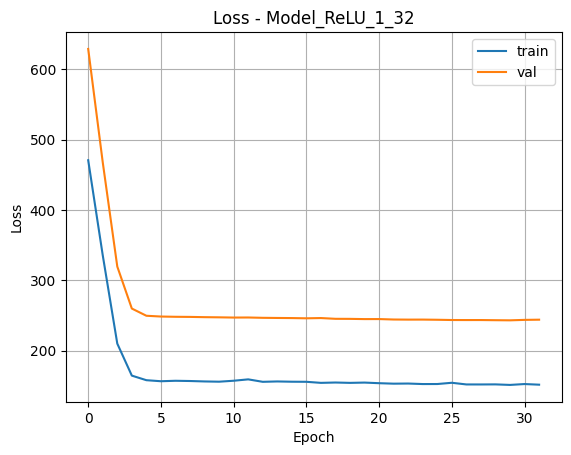

MAE test (Model_ReLU_1_32): 9.2554
MSE test (Model_ReLU_1_32): 158.0204
RMSE test (Model_ReLU_1_32): 12.5706


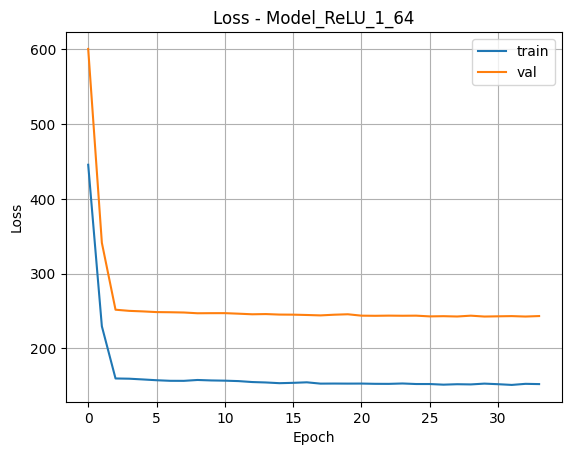

MAE test (Model_ReLU_1_64): 9.3284
MSE test (Model_ReLU_1_64): 158.6036
RMSE test (Model_ReLU_1_64): 12.5938


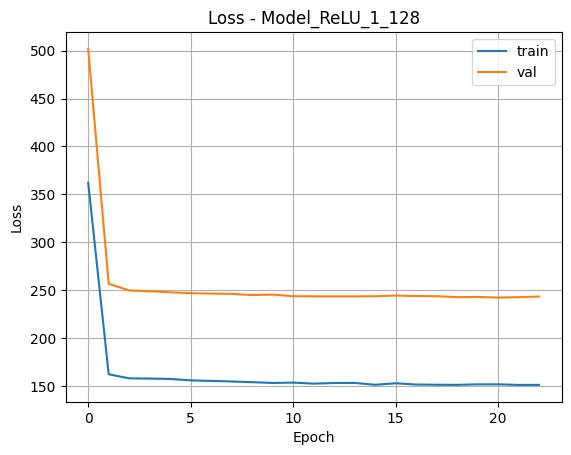

MAE test (Model_ReLU_1_128): 9.3479
MSE test (Model_ReLU_1_128): 159.8163
RMSE test (Model_ReLU_1_128): 12.6418


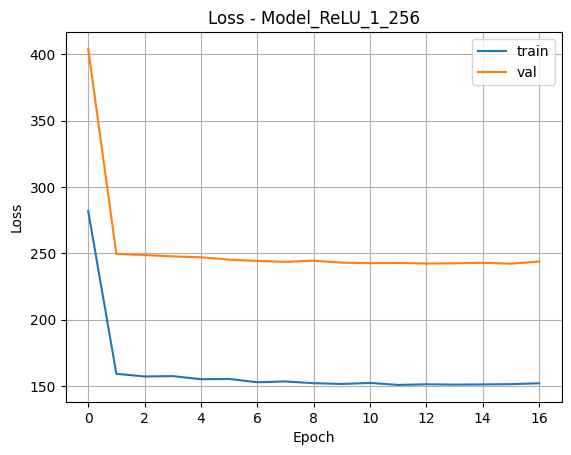

MAE test (Model_ReLU_1_256): 9.3324
MSE test (Model_ReLU_1_256): 161.2001
RMSE test (Model_ReLU_1_256): 12.6965

--- Modelos ReLU con 2 capas ocultas ---


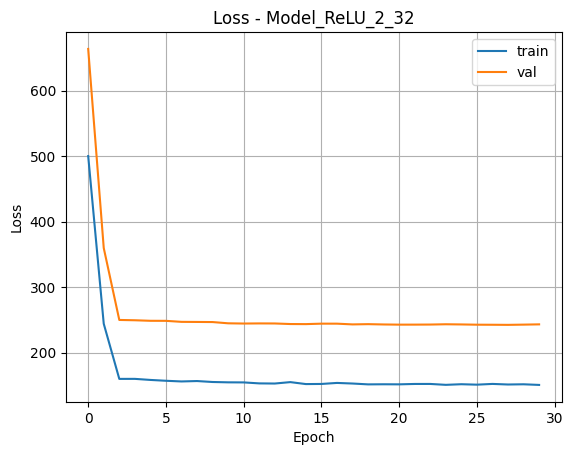

MAE test (Model_ReLU_2_32): 9.3748
MSE test (Model_ReLU_2_32): 159.9213
RMSE test (Model_ReLU_2_32): 12.6460


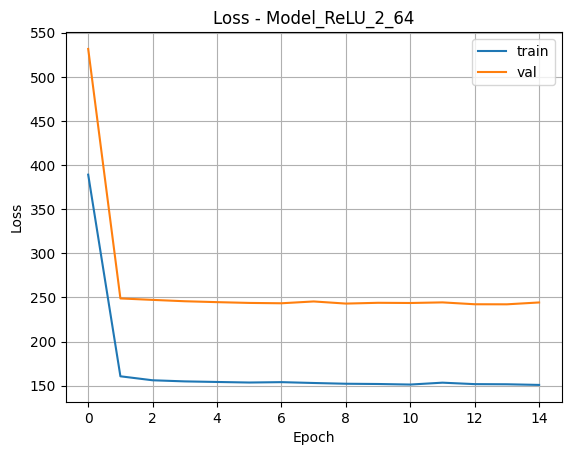

MAE test (Model_ReLU_2_64): 9.3146
MSE test (Model_ReLU_2_64): 161.9600
RMSE test (Model_ReLU_2_64): 12.7264


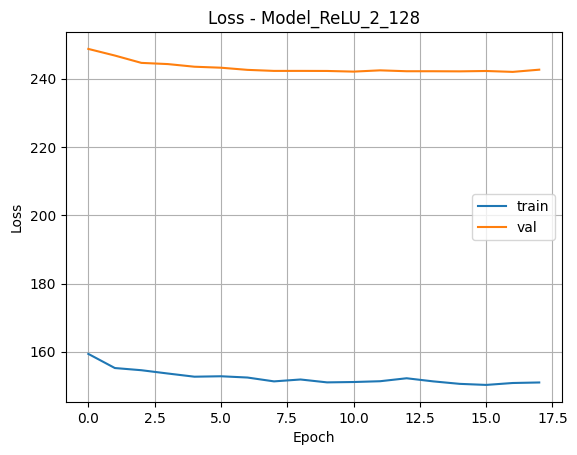

MAE test (Model_ReLU_2_128): 9.4870
MSE test (Model_ReLU_2_128): 161.4280
RMSE test (Model_ReLU_2_128): 12.7054


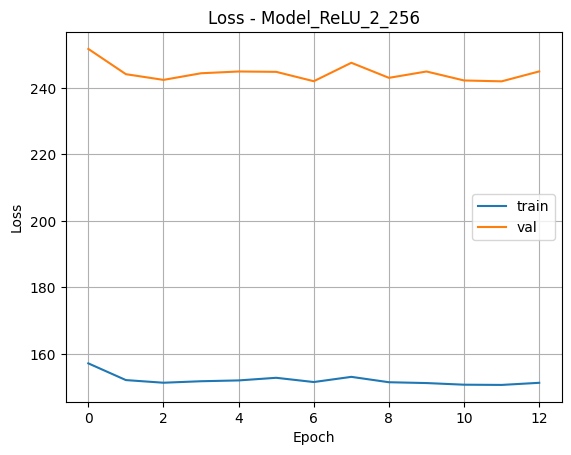

MAE test (Model_ReLU_2_256): 9.3690
MSE test (Model_ReLU_2_256): 164.9992
RMSE test (Model_ReLU_2_256): 12.8452

--- Modelos Sigmoid con 1 capa oculta ---


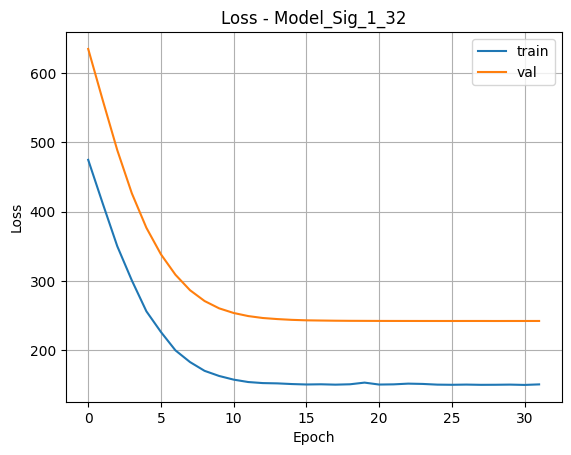

MAE test (Model_Sig_1_32): 9.5849
MSE test (Model_Sig_1_32): 163.1485
RMSE test (Model_Sig_1_32): 12.7730


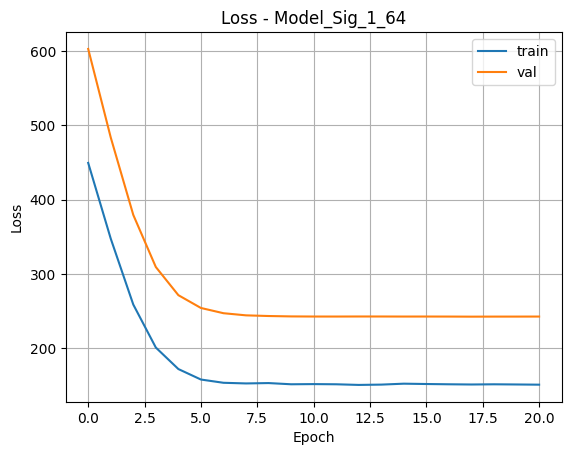

MAE test (Model_Sig_1_64): 9.5378
MSE test (Model_Sig_1_64): 161.7619
RMSE test (Model_Sig_1_64): 12.7186


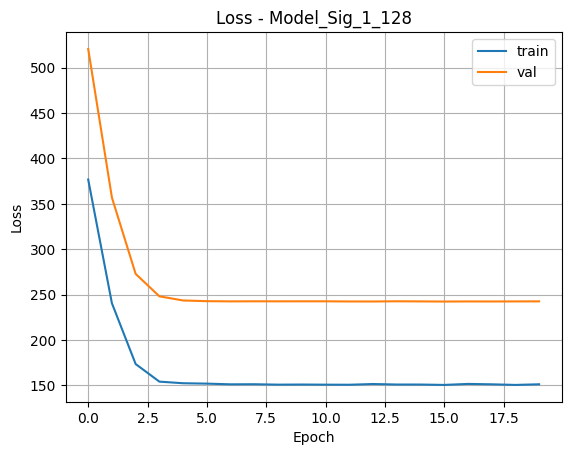

MAE test (Model_Sig_1_128): 9.4997
MSE test (Model_Sig_1_128): 161.1746
RMSE test (Model_Sig_1_128): 12.6955


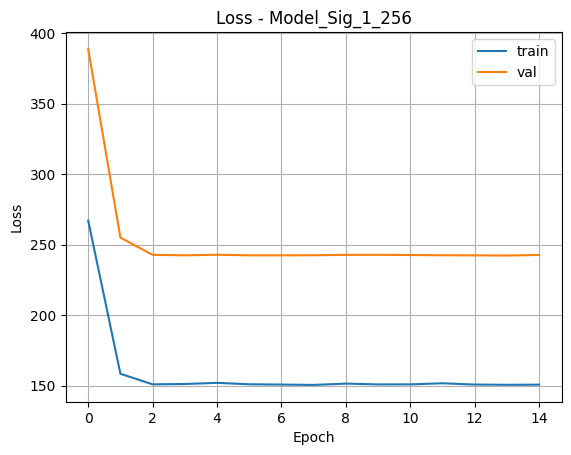

MAE test (Model_Sig_1_256): 9.5023
MSE test (Model_Sig_1_256): 161.6363
RMSE test (Model_Sig_1_256): 12.7136

--- Modelos Sigmoid con 2 capas ocultas ---


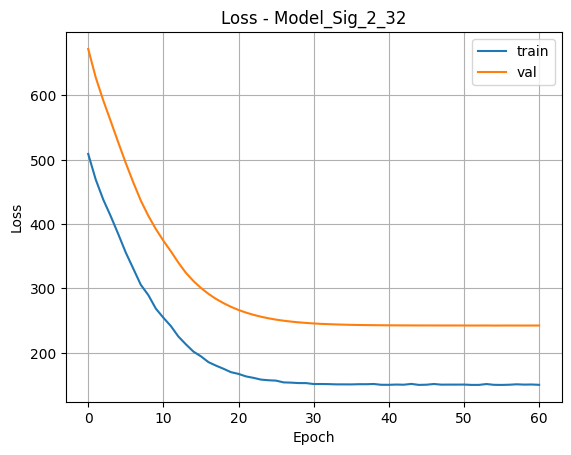

MAE test (Model_Sig_2_32): 9.6425
MSE test (Model_Sig_2_32): 165.0941
RMSE test (Model_Sig_2_32): 12.8489


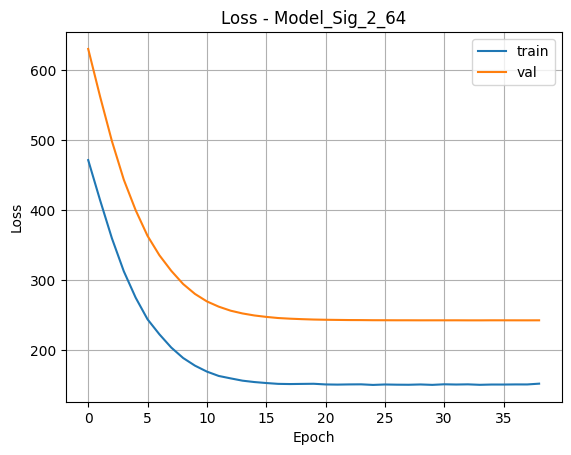

MAE test (Model_Sig_2_64): 9.6441
MSE test (Model_Sig_2_64): 165.0619
RMSE test (Model_Sig_2_64): 12.8476


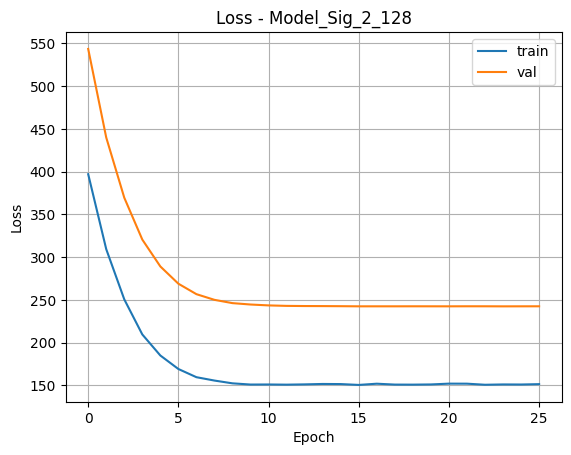

MAE test (Model_Sig_2_128): 9.6443
MSE test (Model_Sig_2_128): 165.0524
RMSE test (Model_Sig_2_128): 12.8473


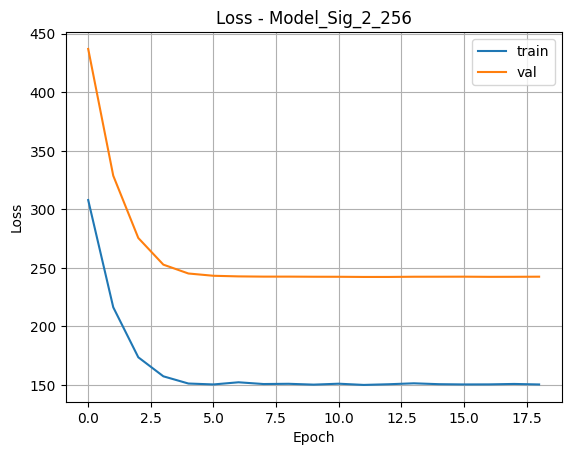

MAE test (Model_Sig_2_256): 9.6380
MSE test (Model_Sig_2_256): 165.1177
RMSE test (Model_Sig_2_256): 12.8498


(9.638039588928223, 165.11767578125)

In [21]:
def plot_and_evaluate(model, history, name="model"):

    hist_train = history['train']
    hist_val = history['val']

    plt. figure()
    plt.plot(hist_train, label='train')
    plt.plot(hist_val, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss - {name}')
    plt.legend()
    plt.grid(True)
    plt.show()


    model. eval()
    y_pred, y_true = test_model(model, WAGE_test)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f'MAE test ({name}): {mae:.4f}')
    print(f'MSE test ({name}): {mse:.4f}')
    print(f'RMSE test ({name}): {rmse:.4f}')

    return mae, mse


print("\n--- Modelos ReLU con 1 capa oculta ---")

plot_and_evaluate(Model_ReLU_1_32, history_relu_1_32, name="Model_ReLU_1_32")
plot_and_evaluate(Model_ReLU_1_64, history_relu_1_64, name="Model_ReLU_1_64")
plot_and_evaluate(Model_ReLU_1_128, history_relu_1_128, name="Model_ReLU_1_128")
plot_and_evaluate(Model_ReLU_1_256, history_relu_1_256, name="Model_ReLU_1_256")

print("\n--- Modelos ReLU con 2 capas ocultas ---")

plot_and_evaluate(Model_ReLU_2_32, history_relu_2_32, name="Model_ReLU_2_32")
plot_and_evaluate(Model_ReLU_2_64, history_relu_2_64, name="Model_ReLU_2_64")
plot_and_evaluate(Model_ReLU_2_128, history_relu_2_128, name="Model_ReLU_2_128")
plot_and_evaluate(Model_ReLU_2_256, history_relu_2_256, name="Model_ReLU_2_256")

print("\n--- Modelos Sigmoid con 1 capa oculta ---")

plot_and_evaluate(Model_Sig_1_32, history_sig_1_32, name="Model_Sig_1_32")
plot_and_evaluate(Model_Sig_1_64, history_sig_1_64, name="Model_Sig_1_64")
plot_and_evaluate(Model_Sig_1_128, history_sig_1_128, name="Model_Sig_1_128")
plot_and_evaluate(Model_Sig_1_256, history_sig_1_256, name="Model_Sig_1_256")

print("\n--- Modelos Sigmoid con 2 capas ocultas ---")

plot_and_evaluate(Model_Sig_2_32, history_sig_2_32, name="Model_Sig_2_32")
plot_and_evaluate(Model_Sig_2_64, history_sig_2_64, name="Model_Sig_2_64")
plot_and_evaluate(Model_Sig_2_128, history_sig_2_128, name="Model_Sig_2_128")
plot_and_evaluate(Model_Sig_2_256, history_sig_2_256, name="Model_Sig_2_256")

Viendo los resultados obtenidos, podemos ver que todos los modelos entrenados alcanzan un rendimiento similar en términos de error de predicción.
El mejor modelo es ReLU_1_32 (1 capa oculta con 32 neuronas), con MAE = 9.26 $/h y MSE = 158.02, superando a todas las arquitecturas más complejas.

Se observa claramente que los modelos con función de activación ReLU presentan un rendimiento superior a los que usan Sigmoid, con una diferencia promedio de aproximadamente 0.3 $/h en MAE, y que aumentar el número de capas o de neuronas degrada el rendimiento, evidenciando sobreajuste debido al tamaño limitado del dataset. Los modelos Sigmoid con 2 capas, obtienen resultados practicamente idénticos, esto nos sugiere un problema que impide el aprendizaje diferenciado.


En conjunto, esto sugiere que el problema de predicción de salarios con un modelo con varianza constante, tiene limitaciones que impiden reducir más el error, independientemente de la arquitectura utilizada. Los errores obtenidos (RMSE ≈ 12.5-12.8 $/h) reflejan que este tipo de modelo no captura adecuadamente la heterocedasticidad identificada en el apartado anterior, donde se demostró que la varianza del salario cambia significativamente según variables como educación y experiencia. Desde el punto de vista práctico, el modelo ReLU_1_32 es el más recomendable por su simplicidad, eficiencia y mejor rendimiento.

# Apartado C

Para este apartado, se entrena un modelo que predice tanto la media como la varianza de la distribución de salarios para cada observación. Para ello, esta vez vamos a poner var=True.
De esta forma se puede capturar la heterocedasticidad identificada en el apartado A.

Se entrenarán las mismas arquitecturas del apartado B y se compararán los resultados con el mejor modelo homocedástico.

In [22]:
torch.manual_seed(42)

print("ENTRENANDO MODELOS HETEROCEDÁSTICOS - ReLU 1 CAPA")

Model_Het_ReLU_1_32 = MLPRegressor(input_size, hidden_layers_sizes=[32],
                                    activation=nn.ReLU, var=True).to('cuda')

Model_Het_ReLU_1_64 = MLPRegressor(input_size, hidden_layers_sizes=[64],
                                    activation=nn. ReLU, var=True). to('cuda')

Model_Het_ReLU_1_128 = MLPRegressor(input_size, hidden_layers_sizes=[128],
                                     activation=nn.ReLU, var=True).to('cuda')

Model_Het_ReLU_1_256 = MLPRegressor(input_size, hidden_layers_sizes=[256],
                                     activation=nn. ReLU, var=True). to('cuda')

optimizer = optim.Adam(Model_Het_ReLU_1_32. parameters(), lr=1e-3)
history_het_relu_1_32 = train_loop(Model_Het_ReLU_1_32, WAGE_train, WAGE_val, optimizer,
                                    patience=10, epochs=500, lossf=RegressionLoss)

optimizer = optim. Adam(Model_Het_ReLU_1_64.parameters(), lr=1e-3)
history_het_relu_1_64 = train_loop(Model_Het_ReLU_1_64, WAGE_train, WAGE_val, optimizer,
                                    patience=10, epochs=500, lossf=RegressionLoss)

optimizer = optim.Adam(Model_Het_ReLU_1_128.parameters(), lr=1e-3)
history_het_relu_1_128 = train_loop(Model_Het_ReLU_1_128, WAGE_train, WAGE_val, optimizer,
                                     patience=10, epochs=500, lossf=RegressionLoss)

optimizer = optim. Adam(Model_Het_ReLU_1_256.parameters(), lr=1e-3)
history_het_relu_1_256 = train_loop(Model_Het_ReLU_1_256, WAGE_train, WAGE_val, optimizer,
                                     patience=10, epochs=500, lossf=RegressionLoss)


ENTRENANDO MODELOS HETEROCEDÁSTICOS - ReLU 1 CAPA


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [23]:
print("ENTRENANDO MODELOS HETEROCEDÁSTICOS - ReLU 2 CAPAS")

Model_Het_ReLU_2_32 = MLPRegressor(input_size, hidden_layers_sizes=[32, 16],
                                    activation=nn.ReLU, var=True).to('cuda')

Model_Het_ReLU_2_64 = MLPRegressor(input_size, hidden_layers_sizes=[64, 32],
                                    activation=nn.ReLU, var=True).to('cuda')

Model_Het_ReLU_2_128 = MLPRegressor(input_size, hidden_layers_sizes=[128, 64],
                                     activation=nn.ReLU, var=True).to('cuda')

Model_Het_ReLU_2_256 = MLPRegressor(input_size, hidden_layers_sizes=[256, 128],
                                     activation=nn.ReLU, var=True).to('cuda')

optimizer = optim.Adam(Model_Het_ReLU_2_32.parameters(), lr=1e-3)
history_het_relu_2_32 = train_loop(Model_Het_ReLU_2_32, WAGE_train, WAGE_val, optimizer,
                                    patience=10, epochs=500, lossf=RegressionLoss)

optimizer = optim.Adam(Model_Het_ReLU_2_64.parameters(), lr=1e-3)
history_het_relu_2_64 = train_loop(Model_Het_ReLU_2_64, WAGE_train, WAGE_val, optimizer,
                                    patience=10, epochs=500, lossf=RegressionLoss)

optimizer = optim.Adam(Model_Het_ReLU_2_128.parameters(), lr=1e-3)
history_het_relu_2_128 = train_loop(Model_Het_ReLU_2_128, WAGE_train, WAGE_val, optimizer,
                                     patience=10, epochs=500, lossf=RegressionLoss)

optimizer = optim.Adam(Model_Het_ReLU_2_256.parameters(), lr=1e-3)
history_het_relu_2_256 = train_loop(Model_Het_ReLU_2_256, WAGE_train, WAGE_val, optimizer,
                                     patience=10, epochs=500, lossf=RegressionLoss)


ENTRENANDO MODELOS HETEROCEDÁSTICOS - ReLU 2 CAPAS


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [24]:
print("ENTRENANDO MODELOS HETEROCEDÁSTICOS - Sigmoid 1 CAPA")

Model_Het_Sig_1_32 = MLPRegressor(input_size, hidden_layers_sizes=[32],
                                   activation=nn.Sigmoid, var=True).to('cuda')

Model_Het_Sig_1_64 = MLPRegressor(input_size, hidden_layers_sizes=[64],
                                   activation=nn.Sigmoid, var=True).to('cuda')

Model_Het_Sig_1_128 = MLPRegressor(input_size, hidden_layers_sizes=[128],
                                    activation=nn. Sigmoid, var=True).to('cuda')

Model_Het_Sig_1_256 = MLPRegressor(input_size, hidden_layers_sizes=[256],
                                    activation=nn.Sigmoid, var=True).to('cuda')

optimizer = optim.Adam(Model_Het_Sig_1_32. parameters(), lr=1e-3)
history_het_sig_1_32 = train_loop(Model_Het_Sig_1_32, WAGE_train, WAGE_val, optimizer,
                                   patience=10, epochs=500, lossf=RegressionLoss)

optimizer = optim.Adam(Model_Het_Sig_1_64.parameters(), lr=1e-3)
history_het_sig_1_64 = train_loop(Model_Het_Sig_1_64, WAGE_train, WAGE_val, optimizer,
                                   patience=10, epochs=500, lossf=RegressionLoss)

optimizer = optim.Adam(Model_Het_Sig_1_128.parameters(), lr=1e-3)
history_het_sig_1_128 = train_loop(Model_Het_Sig_1_128, WAGE_train, WAGE_val, optimizer,
                                    patience=10, epochs=500, lossf=RegressionLoss)

optimizer = optim.Adam(Model_Het_Sig_1_256.parameters(), lr=1e-3)
history_het_sig_1_256 = train_loop(Model_Het_Sig_1_256, WAGE_train, WAGE_val, optimizer,
                                    patience=10, epochs=500, lossf=RegressionLoss)


ENTRENANDO MODELOS HETEROCEDÁSTICOS - Sigmoid 1 CAPA


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [25]:
print("ENTRENANDO MODELOS HETEROCEDÁSTICOS - Sigmoid 2 CAPAS")

Model_Het_Sig_2_32 = MLPRegressor(input_size, hidden_layers_sizes=[32, 16],
                                   activation=nn.Sigmoid, var=True). to('cuda')

Model_Het_Sig_2_64 = MLPRegressor(input_size, hidden_layers_sizes=[64, 32],
                                   activation=nn.Sigmoid, var=True).to('cuda')

Model_Het_Sig_2_128 = MLPRegressor(input_size, hidden_layers_sizes=[128, 64],
                                    activation=nn.Sigmoid, var=True).to('cuda')

Model_Het_Sig_2_256 = MLPRegressor(input_size, hidden_layers_sizes=[256, 128],
                                    activation=nn. Sigmoid, var=True).to('cuda')

optimizer = optim.Adam(Model_Het_Sig_2_32.parameters(), lr=1e-3)
history_het_sig_2_32 = train_loop(Model_Het_Sig_2_32, WAGE_train, WAGE_val, optimizer,
                                   patience=10, epochs=500, lossf=RegressionLoss)

optimizer = optim.Adam(Model_Het_Sig_2_64. parameters(), lr=1e-3)
history_het_sig_2_64 = train_loop(Model_Het_Sig_2_64, WAGE_train, WAGE_val, optimizer,
                                   patience=10, epochs=500, lossf=RegressionLoss)

optimizer = optim.Adam(Model_Het_Sig_2_128.parameters(), lr=1e-3)
history_het_sig_2_128 = train_loop(Model_Het_Sig_2_128, WAGE_train, WAGE_val, optimizer,
                                    patience=10, epochs=500, lossf=RegressionLoss)

optimizer = optim.Adam(Model_Het_Sig_2_256.parameters(), lr=1e-3)
history_het_sig_2_256 = train_loop(Model_Het_Sig_2_256, WAGE_train, WAGE_val, optimizer,
                                    patience=10, epochs=500, lossf=RegressionLoss)


ENTRENANDO MODELOS HETEROCEDÁSTICOS - Sigmoid 2 CAPAS


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [26]:
def test_model_heteroscedastic(model, test):

    preds = []
    true = []
    for i, (data, labels) in enumerate(test):
        inputs = data.to('cuda')
        outputs = model(inputs)
        preds.append(outputs.detach().cpu().numpy())
        true.append(labels.detach(). cpu().numpy())


    preds_concat = np.concatenate(preds)

    y_pred_mean = preds_concat[:, 0]
    y_pred_logvar = preds_concat[:, 1]
    y_pred_var = np.exp(y_pred_logvar)

    y_true = np.concatenate(true). flatten()

    return y_pred_mean, y_pred_var, y_true


def plot_and_evaluate_heteroscedastic(model, history, name="model"):

    hist_train = history['train']
    hist_val = history['val']

    plt.figure()
    plt.plot(hist_train, label='train')
    plt.plot(hist_val, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('NLL Loss')
    plt.title(f'Loss - {name}')
    plt. legend()
    plt.grid(True)
    plt.show()


    model.eval()
    y_pred_mean, y_pred_var, y_true = test_model_heteroscedastic(model, WAGE_test)

    mae = mean_absolute_error(y_true, y_pred_mean)
    mse = mean_squared_error(y_true, y_pred_mean)
    rmse = np.sqrt(mse)


    var_mean = y_pred_var.mean()
    var_std = y_pred_var.std()

    print(f'MAE test ({name}): {mae:.4f}')
    print(f'MSE test ({name}): {mse:.4f}')
    print(f'RMSE test ({name}): {rmse:.4f}')
    print(f'Varianza predicha - Media: {var_mean:.4f}, Std: {var_std:.4f}')

    return mae, mse, var_mean


EVALUACIÓN DE MODELOS HETEROCEDÁSTICOS

--- Modelos Heterocedásticos ReLU con 1 capa ---


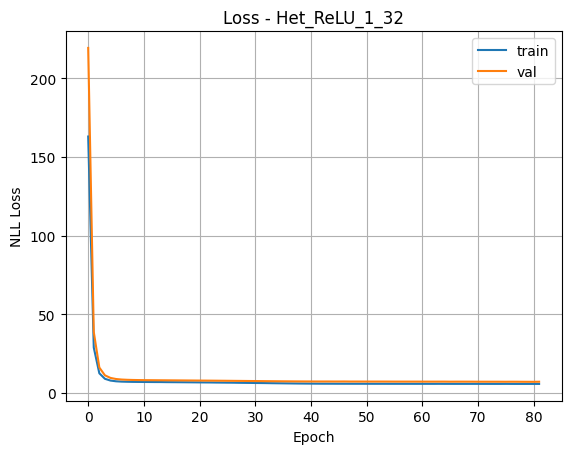

MAE test (Het_ReLU_1_32): 8.6043
MSE test (Het_ReLU_1_32): 145.9156
RMSE test (Het_ReLU_1_32): 12.0796
Varianza predicha - Media: 128.4929, Std: 70.2532


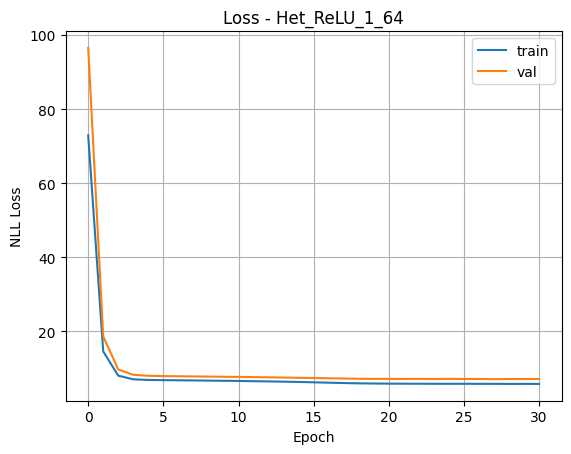

MAE test (Het_ReLU_1_64): 8.7074
MSE test (Het_ReLU_1_64): 149.5329
RMSE test (Het_ReLU_1_64): 12.2284
Varianza predicha - Media: 131.8906, Std: 69.1433


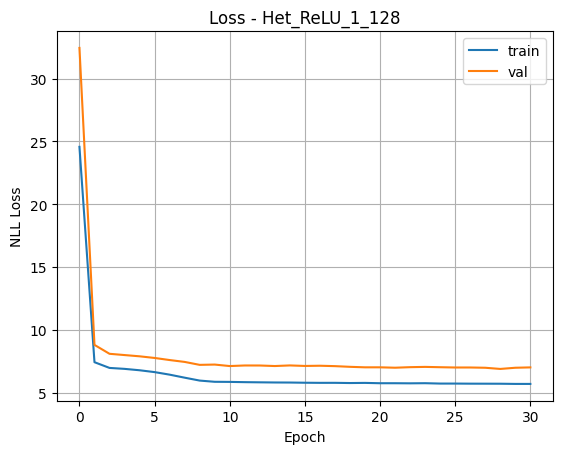

MAE test (Het_ReLU_1_128): 8.5490
MSE test (Het_ReLU_1_128): 144.0588
RMSE test (Het_ReLU_1_128): 12.0024
Varianza predicha - Media: 102.9354, Std: 52.0907


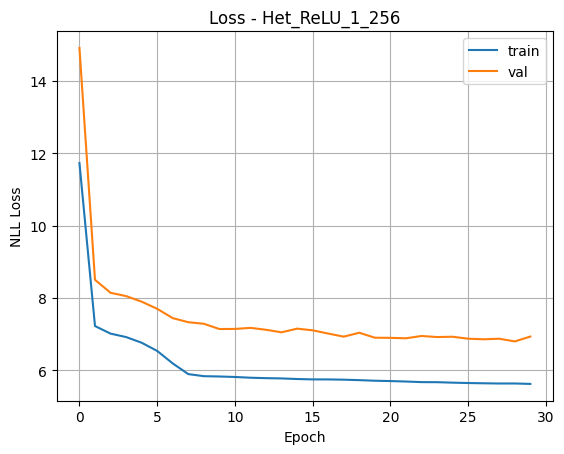

MAE test (Het_ReLU_1_256): 8.4297
MSE test (Het_ReLU_1_256): 141.9890
RMSE test (Het_ReLU_1_256): 11.9159
Varianza predicha - Media: 102.4887, Std: 57.9450

--- Modelos Heterocedásticos ReLU con 2 capas ---


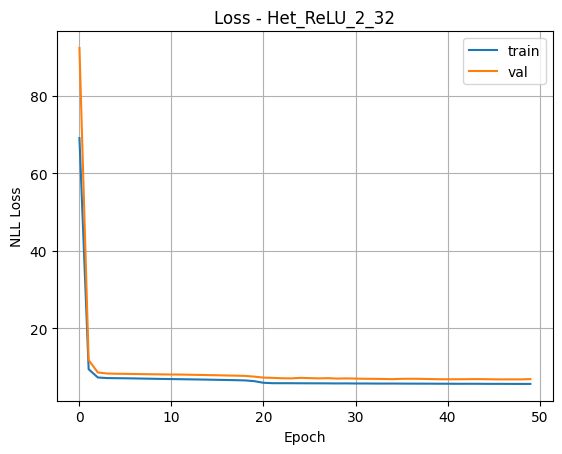

MAE test (Het_ReLU_2_32): 8.2705
MSE test (Het_ReLU_2_32): 138.9838
RMSE test (Het_ReLU_2_32): 11.7891
Varianza predicha - Media: 104.8417, Std: 64.7310


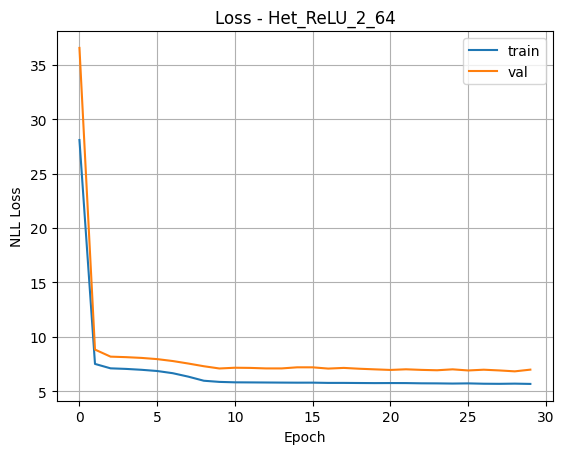

MAE test (Het_ReLU_2_64): 8.5304
MSE test (Het_ReLU_2_64): 142.0773
RMSE test (Het_ReLU_2_64): 11.9196
Varianza predicha - Media: 103.6537, Std: 50.0547


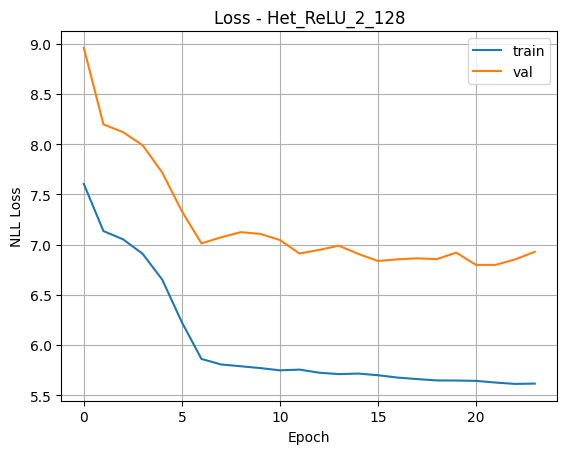

MAE test (Het_ReLU_2_128): 8.4940
MSE test (Het_ReLU_2_128): 142.6287
RMSE test (Het_ReLU_2_128): 11.9427
Varianza predicha - Media: 97.5630, Std: 58.6570


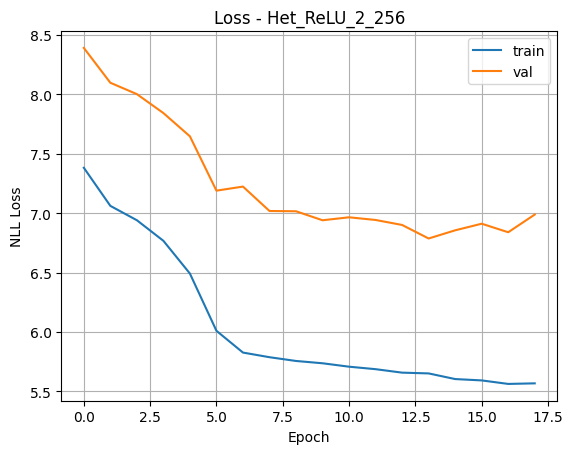

MAE test (Het_ReLU_2_256): 8.3684
MSE test (Het_ReLU_2_256): 142.7740
RMSE test (Het_ReLU_2_256): 11.9488
Varianza predicha - Media: 94.8687, Std: 61.1125

--- Modelos Heterocedásticos Sigmoid con 1 capa ---


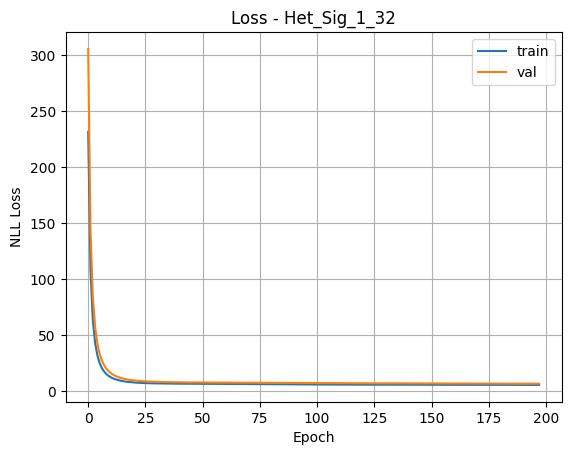

MAE test (Het_Sig_1_32): 8.6640
MSE test (Het_Sig_1_32): 147.5741
RMSE test (Het_Sig_1_32): 12.1480
Varianza predicha - Media: 108.8230, Std: 53.6703


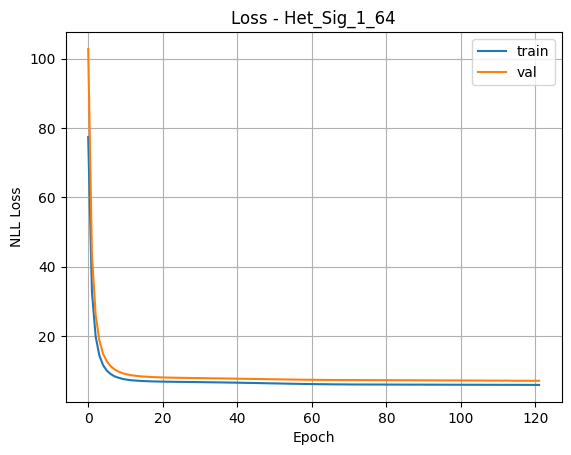

MAE test (Het_Sig_1_64): 8.8829
MSE test (Het_Sig_1_64): 154.8044
RMSE test (Het_Sig_1_64): 12.4420
Varianza predicha - Media: 125.5083, Std: 49.9491


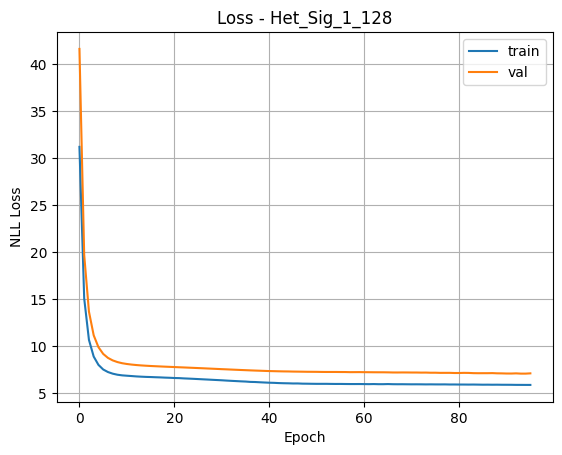

MAE test (Het_Sig_1_128): 8.9449
MSE test (Het_Sig_1_128): 155.8389
RMSE test (Het_Sig_1_128): 12.4835
Varianza predicha - Media: 126.0981, Std: 46.0283


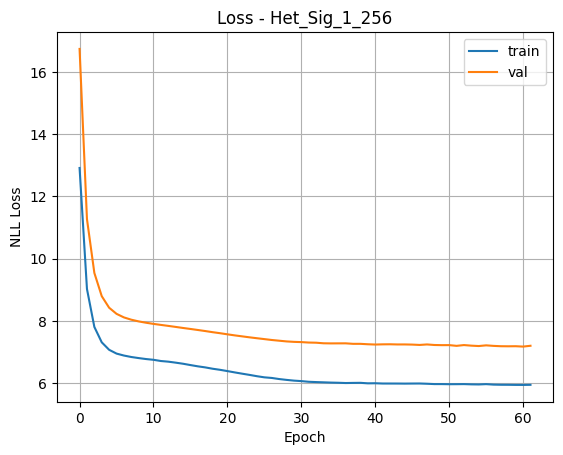

MAE test (Het_Sig_1_256): 9.0795
MSE test (Het_Sig_1_256): 159.2631
RMSE test (Het_Sig_1_256): 12.6199
Varianza predicha - Media: 131.4598, Std: 39.0345

--- Modelos Heterocedásticos Sigmoid con 2 capas ---


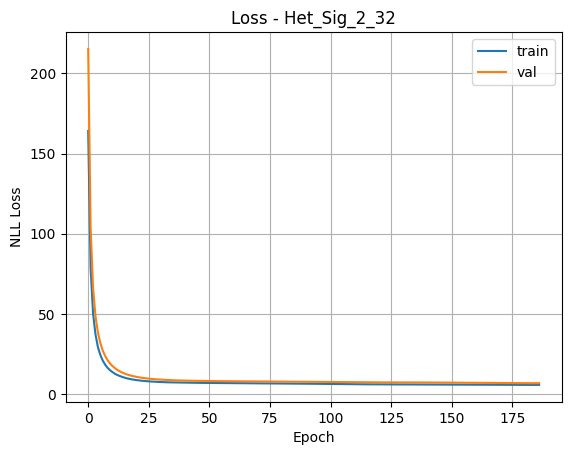

MAE test (Het_Sig_2_32): 8.7394
MSE test (Het_Sig_2_32): 152.7645
RMSE test (Het_Sig_2_32): 12.3598
Varianza predicha - Media: 112.6527, Std: 55.4602


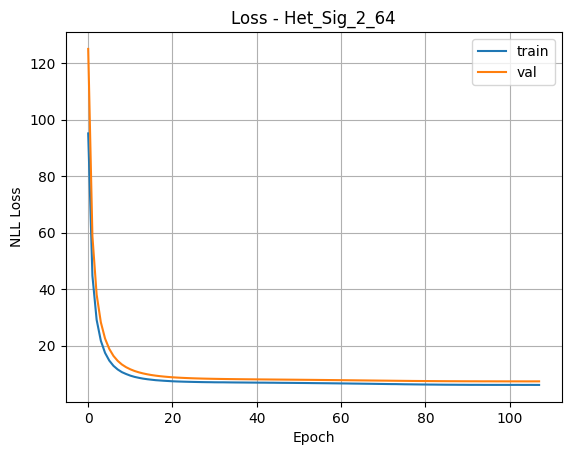

MAE test (Het_Sig_2_64): 9.5362
MSE test (Het_Sig_2_64): 165.3738
RMSE test (Het_Sig_2_64): 12.8598
Varianza predicha - Media: 143.8487, Std: 5.7772


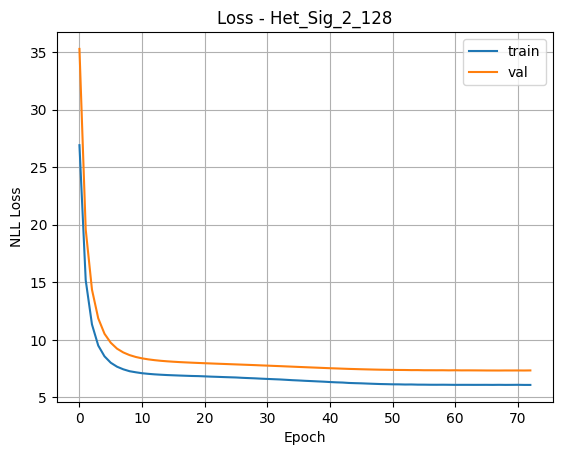

MAE test (Het_Sig_2_128): 9.5647
MSE test (Het_Sig_2_128): 164.6885
RMSE test (Het_Sig_2_128): 12.8331
Varianza predicha - Media: 143.7279, Std: 6.5738


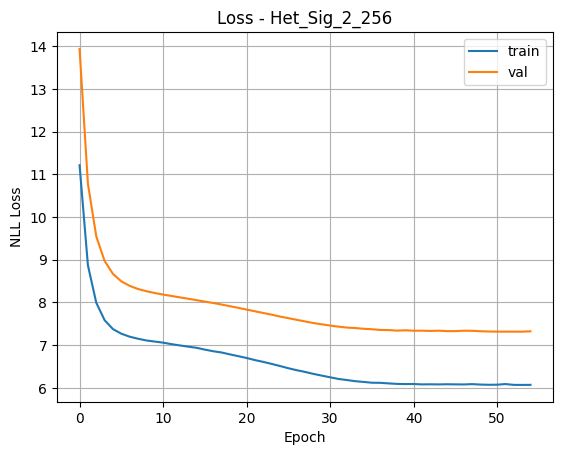

MAE test (Het_Sig_2_256): 9.5204
MSE test (Het_Sig_2_256): 164.6902
RMSE test (Het_Sig_2_256): 12.8332
Varianza predicha - Media: 142.1083, Std: 12.2781


In [27]:
print("\n" + "="*80)
print("EVALUACIÓN DE MODELOS HETEROCEDÁSTICOS")


results_het = []

print("\n--- Modelos Heterocedásticos ReLU con 1 capa ---")

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_ReLU_1_32, history_het_relu_1_32, "Het_ReLU_1_32")
results_het.append(['Het_ReLU_1_32', 1, 32, mae, mse, var_mean])

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_ReLU_1_64, history_het_relu_1_64, "Het_ReLU_1_64")
results_het.append(['Het_ReLU_1_64', 1, 64, mae, mse, var_mean])

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_ReLU_1_128, history_het_relu_1_128, "Het_ReLU_1_128")
results_het.append(['Het_ReLU_1_128', 1, 128, mae, mse, var_mean])

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_ReLU_1_256, history_het_relu_1_256, "Het_ReLU_1_256")
results_het.append(['Het_ReLU_1_256', 1, 256, mae, mse, var_mean])

print("\n--- Modelos Heterocedásticos ReLU con 2 capas ---")

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_ReLU_2_32, history_het_relu_2_32, "Het_ReLU_2_32")
results_het.append(['Het_ReLU_2_32', 2, 32, mae, mse, var_mean])

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_ReLU_2_64, history_het_relu_2_64, "Het_ReLU_2_64")
results_het.append(['Het_ReLU_2_64', 2, 64, mae, mse, var_mean])

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_ReLU_2_128, history_het_relu_2_128, "Het_ReLU_2_128")
results_het.append(['Het_ReLU_2_128', 2, 128, mae, mse, var_mean])

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_ReLU_2_256, history_het_relu_2_256, "Het_ReLU_2_256")
results_het. append(['Het_ReLU_2_256', 2, 256, mae, mse, var_mean])

print("\n--- Modelos Heterocedásticos Sigmoid con 1 capa ---")

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_Sig_1_32, history_het_sig_1_32, "Het_Sig_1_32")
results_het.append(['Het_Sig_1_32', 1, 32, mae, mse, var_mean])

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_Sig_1_64, history_het_sig_1_64, "Het_Sig_1_64")
results_het.append(['Het_Sig_1_64', 1, 64, mae, mse, var_mean])

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_Sig_1_128, history_het_sig_1_128, "Het_Sig_1_128")
results_het.append(['Het_Sig_1_128', 1, 128, mae, mse, var_mean])

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_Sig_1_256, history_het_sig_1_256, "Het_Sig_1_256")
results_het.append(['Het_Sig_1_256', 1, 256, mae, mse, var_mean])

print("\n--- Modelos Heterocedásticos Sigmoid con 2 capas ---")

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_Sig_2_32, history_het_sig_2_32, "Het_Sig_2_32")
results_het.append(['Het_Sig_2_32', 2, 32, mae, mse, var_mean])

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_Sig_2_64, history_het_sig_2_64, "Het_Sig_2_64")
results_het.append(['Het_Sig_2_64', 2, 64, mae, mse, var_mean])

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_Sig_2_128, history_het_sig_2_128, "Het_Sig_2_128")
results_het. append(['Het_Sig_2_128', 2, 128, mae, mse, var_mean])

mae, mse, var_mean = plot_and_evaluate_heteroscedastic(Model_Het_Sig_2_256, history_het_sig_2_256, "Het_Sig_2_256")
results_het.append(['Het_Sig_2_256', 2, 256, mae, mse, var_mean])


In [37]:
best_mse = float('inf')
best_het_model_name = None
for result in results_het:
    if result[4] < best_mse:
        best_mse = result[4]
        best_het_model_name = result[0]

print("Mejor heterocedástico: {best_het_model_name}")


Model_ReLU_1_32.eval()
y_pred_homo, y_true_homo = test_model(Model_ReLU_1_32, WAGE_test)

best_het_model = eval(f"Model_{best_het_model_name}")
best_het_model. eval()
y_pred_het_mean, y_pred_het_var, y_true_het = test_model_heteroscedastic(best_het_model, WAGE_test)


Mejor heterocedástico: {best_het_model_name}


De los resultados observamos que el modelo heterocedástico mejora significativamente sobre el homocedástico, reduciendo el MAE de 9.26 a 8.27 $/h y el MSE de 158.02 a 138.98, gracias a su capacidad para modelar la varianza cambiante de los salarios.
El mejor modelo es Het_ReLU_2_32 (2 capas con 32 neuronas y ReLU), destacando que en modelos heterocedásticos las arquitecturas con 2 capas funcionan mejor que las de 1 capa, a diferencia de los homocedásticos donde se observaba overfitting. Los modelos con activación ReLU siguen siendo superiores a Sigmoid.


A continuación se implementa el código de residuos de las dos regresiones y las predicciones contra los valores reales.


--- Gráfico 1: Residuos ---


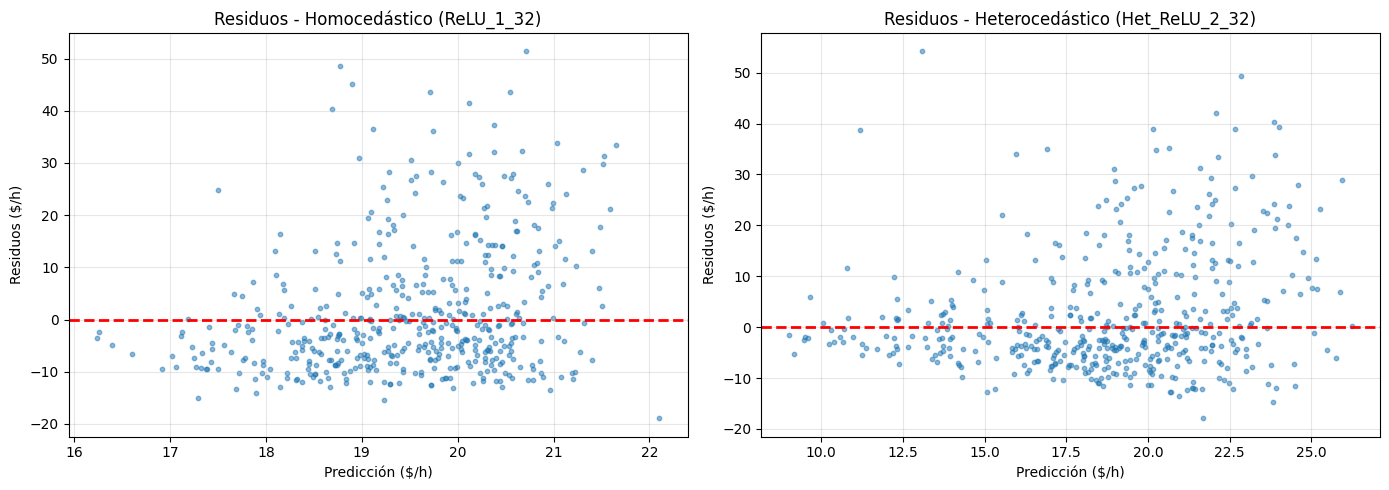

In [38]:
print("\n--- Gráfico 1: Residuos ---")

residuos_homo = y_true_homo - y_pred_homo
residuos_het = y_true_het - y_pred_het_mean

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_pred_homo, residuos_homo, alpha=0.5, s=10)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicción ($/h)')
axes[0].set_ylabel('Residuos ($/h)')
axes[0]. set_title('Residuos - Homocedástico (ReLU_1_32)')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_pred_het_mean, residuos_het, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicción ($/h)')
axes[1].set_ylabel('Residuos ($/h)')
axes[1].set_title(f'Residuos - Heterocedástico ({best_het_model_name})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt. show()


Podemos observar que se muestran diferencias sutiles entre ambos modelos. El modelo homocedástico presenta residuos con una dispersión constante centrado alrededor del 0, llo cual cuadra con la suposición de varianza fija.

En cambio, el modelo heterocedástico muestra residuos con dispersioln ligeramente más controlada, especialmente en el rango medio, lo que sugiere que captura mejor la variabilidad de los datos al modelar explícitamente la varianza cambiante


Ambos modelos tienen residuos centrados en cero, pero el heterocedástico logra errores absolutos menores en promedio, confirmando que reconocer y modelar la heterocedasticidad mejora la precisión predictiva.


--- Gráfico 2: Predicciones vs Valores Reales ---


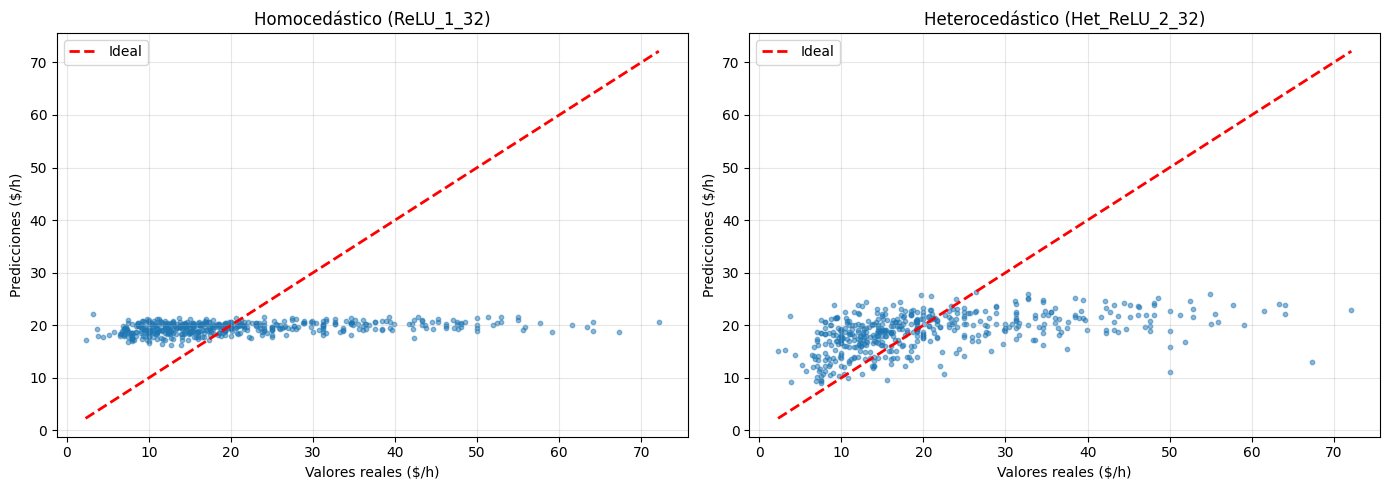

In [39]:
print("--- Gráfico 2: Predicciones vs Valores Reales ---")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_true_homo, y_pred_homo, alpha=0.5, s=10)
axes[0]. plot([y_true_homo.min(), y_true_homo.max()],
             [y_true_homo.min(), y_true_homo.max()],
             'r--', linewidth=2, label='Ideal')
axes[0].set_xlabel('Valores reales ($/h)')
axes[0].set_ylabel('Predicciones ($/h)')
axes[0].set_title('Homocedástico (ReLU_1_32)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1]. scatter(y_true_het, y_pred_het_mean, alpha=0.5, s=10)
axes[1].plot([y_true_het.min(), y_true_het.max()],
             [y_true_het.min(), y_true_het.max()],
             'r--', linewidth=2, label='Ideal')
axes[1].set_xlabel('Valores reales ($/h)')
axes[1].set_ylabel('Predicciones ($/h)')
axes[1].set_title(f'Heterocedástico ({best_het_model_name})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Observando los gráficos resultantes podemos ver que, ambos modelos muestran que la mayoría de los datos se concentran en el rango de salarios bajos-medios (10-25 $/h), con pocas observaciones de salarios altos. El modelo homocedástico tiende a subestimar sistemáticamente los salarios altos, prediciendo valores alrededor de 20 $/h incluso cuando los salarios reales superan los 40-60 $/h, formando una banda horizontal que no sigue la línea ideal. En cambio, el modelo heterocedástico muestra una mejor adherencia a la línea diagonal ideal en todo el rango, especialmente en salarios medios-altos, con puntos más dispersos alrededor de la diagonal que indican mayor capacidad para capturar la variabilidad real.

Esta mejora se refleja en las métricas (MAE: 8.27 vs 9.26), confirmando que modelar la varianza cambiante permite al heterocedástico hacer predicciones más precisas.

--- Gráfico 3: Predicciones vs Experiencia ---


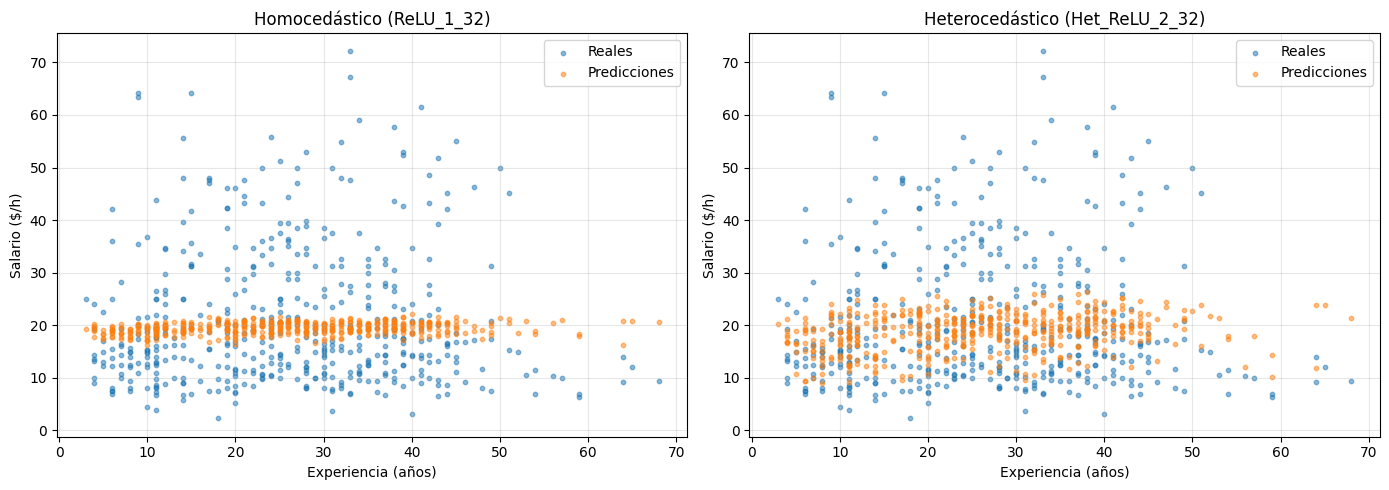

In [40]:
print("--- Gráfico 3: Predicciones vs Experiencia ---")

exper_test = X_test['exper'].values

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0]. scatter(exper_test, y_true_homo, alpha=0.5, s=10, label='Reales')
axes[0].scatter(exper_test, y_pred_homo, alpha=0.5, s=10, label='Predicciones')
axes[0].set_xlabel('Experiencia (años)')
axes[0].set_ylabel('Salario ($/h)')
axes[0].set_title('Homocedástico (ReLU_1_32)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(exper_test, y_true_het, alpha=0.5, s=10, label='Reales')
axes[1].scatter(exper_test, y_pred_het_mean, alpha=0.5, s=10, label='Predicciones')
axes[1].set_xlabel('Experiencia (años)')
axes[1]. set_ylabel('Salario ($/h)')
axes[1]. set_title(f'Heterocedástico ({best_het_model_name})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Ambos modelos capturan correctamente la tendencia general de que mayor experiencia está asociada con salarios más altos, aunque la relación es débil y con gran dispersión. El modelo homocedástico muestra predicciones (los puntos naranjas) formando una banda casi horizontal entre 18-22 $/h, prácticamente insensible a la experiencia, mientras que los valores reales (vistos en azul) muestran gran variabilidad en todos los niveles de experiencia. El modelo heterocedástico presenta predicciones con mayor variabilidad que siguen mejor la dispersión de los datos reales, especialmente notable en experiencias altas (>40 años) donde las predicciones se distribuyen más ampliamente.

Sin embargo, ambos modelos subestiman significativamente los salarios altos (>40 $/h), indicando que la experiencia por sí sola no es suficiente para predecir salarios extremos.

--- Gráfico 4: Predicciones vs Edad ---


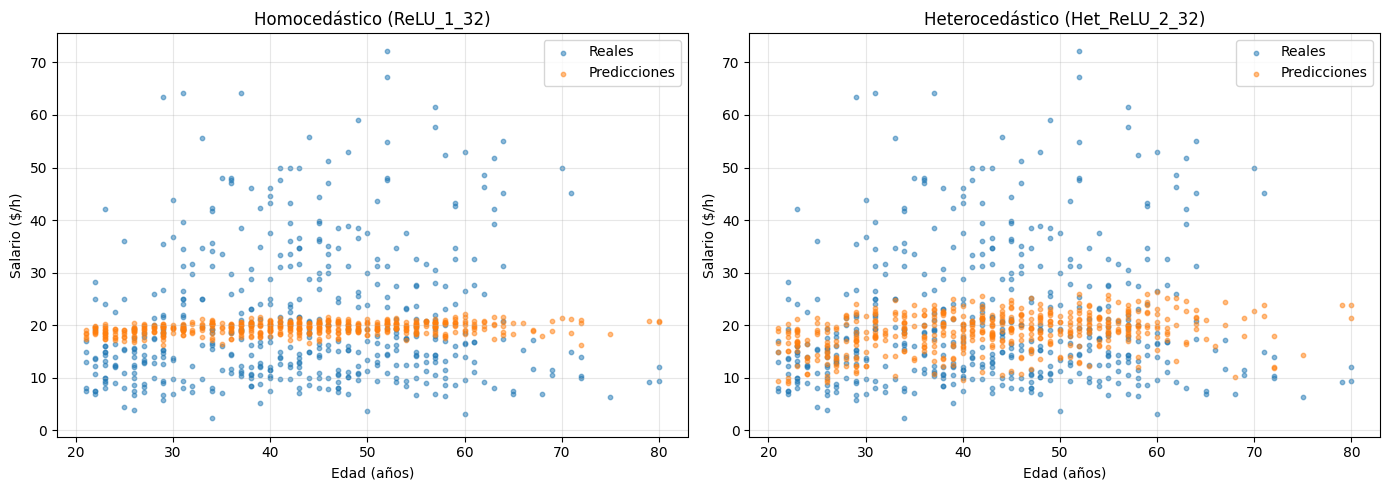

In [41]:
print("--- Gráfico 4: Predicciones vs Edad ---")

age_test = X_test['age'].values

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(age_test, y_true_homo, alpha=0.5, s=10, label='Reales')
axes[0]. scatter(age_test, y_pred_homo, alpha=0.5, s=10, label='Predicciones')
axes[0].set_xlabel('Edad (años)')
axes[0]. set_ylabel('Salario ($/h)')
axes[0]. set_title('Homocedástico (ReLU_1_32)')
axes[0]. legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(age_test, y_true_het, alpha=0.5, s=10, label='Reales')
axes[1].scatter(age_test, y_pred_het_mean, alpha=0.5, s=10, label='Predicciones')
axes[1].set_xlabel('Edad (años)')
axes[1].set_ylabel('Salario ($/h)')
axes[1].set_title(f'Heterocedástico ({best_het_model_name})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt. tight_layout()
plt.show()

El patrón observado es muy similar al de experiencia, dado que ambas variables están altamente correlacionadas.

El modelo homocedástico genera predicciones  en una banda estrecha y casi constante independientemente de la edad, ignorando completamente la gran dispersión de los salarios reales. El modelo heterocedástico muestra predicciones con mayor amplitud que se adaptan mejor a la variabilidad real de los datos.

Ambos modelos fallan sistemáticamente en predecir salarios superiores a 30 $/h, confirmando que la edad (al igual que la experiencia) es un predictor débil para salarios extremos, y que el modelo necesitaría variables adicionales como educación, sector o tipo de empleo para capturar adecuadamente estos casos.

# Apartado D

Para este último apartado se pide representar la varianza que
se predice para el conjunto de test respecto al valor de la variable objetivo.

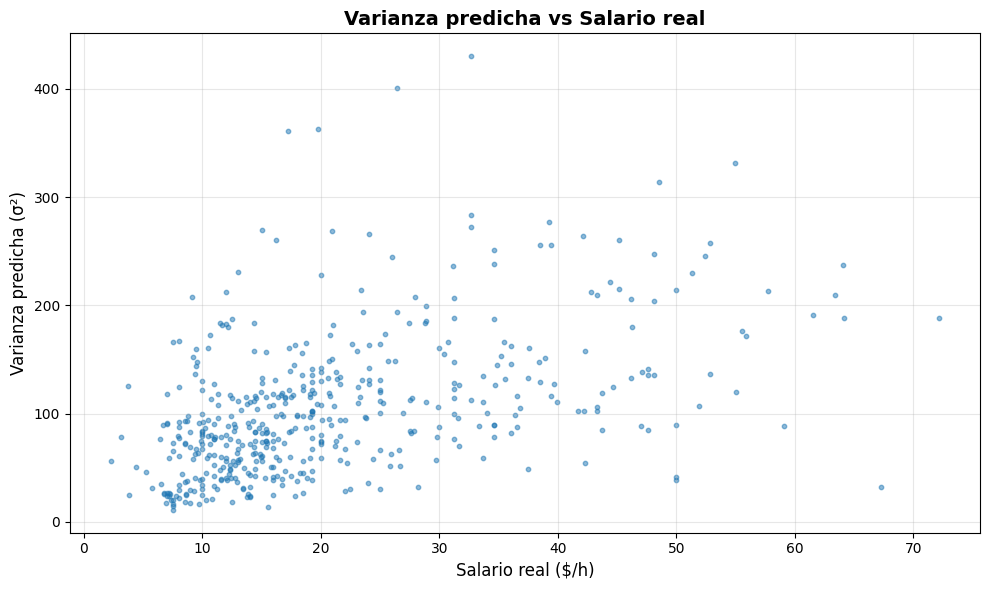

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(y_true_het, y_pred_het_var, alpha=0.5, s=10)
plt.xlabel('Salario real ($/h)', fontsize=12)
plt. ylabel('Varianza predicha (σ²)', fontsize=12)
plt.title('Varianza predicha vs Salario real', fontsize=14, fontweight='bold')
plt. grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

La varianza predicha aumenta sistemáticamente con el salario, reflejando correctamente que los salarios altos son más difíciles de predecir con las variables disponibles (edad, experiencia, educación, horas). El modelo heterocedástico captura esta incertidumbre cambiante, haciendo sus predicciones más honestas y útiles ya que también muestra qué tan seguro se está de esa predicción.